In [11]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.6 MB/s eta 0:00:00a 0:00:010m
Note: you may need to restart the kernel to use updated packages.


In [12]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import timedelta
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb
import nltk
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [26]:
DB_PATH = '../db.sqlite3'
BTC_DAILY = 'btc_daily_ohlcv'
OI_TABLE_NAME = 'open_interest'
FD_TABLE_NAME = 'funding_rates'
NEWS_TABLE_NAME = 'news'


In [ ]:
conn = sqlite3.connect(DB_PATH)
query = f"SELECT * FROM {BTC_DAILY}"
btc_ohlcv = pd.read_sql_query(query, conn)
# btc_ohlcv = pd.read_csv('btc_daily_ohlcv_from_db.csv')
btc_ohlcv['datetime'] = pd.to_datetime(btc_ohlcv['datetime'])
btc_ohlcv.set_index('datetime', inplace=True)
btc_ohlcv.index = btc_ohlcv.index.date

conn.close()

In [28]:
conn = sqlite3.connect(DB_PATH)
query = f"SELECT * FROM {OI_TABLE_NAME}"
df = pd.read_sql_query(query, conn, parse_dates=['timestamp'])
conn.close()

# Ensure timestamp is datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample to daily (1D) frequency
# For open interest, you might want the last value of each day (or you can use mean, first, etc.)
daily_oi = df.resample('1D').mean()  # or .mean(), .first(), etc.

In [29]:
conn = sqlite3.connect(DB_PATH)
query = f"SELECT * FROM {FD_TABLE_NAME}"
df = pd.read_sql_query(query, conn, parse_dates=['funding_time'])
conn.close()

# Ensure timestamp is datetime and set as index
df['funding_time'] = pd.to_datetime(df['funding_time'])
df.set_index('funding_time', inplace=True)

# Resample to daily (1D) frequency
# For open interest, you might want the last value of each day (or you can use mean, first, etc.)
daily_funding_rate = df.drop(columns=['symbol']).resample('1D').last()  # or .mean(), .first(), etc.

In [30]:
conn = sqlite3.connect(DB_PATH)
query = f"SELECT * FROM {NEWS_TABLE_NAME}"
df_news = pd.read_sql_query(query, conn, parse_dates=['date'])
conn.close()

In [31]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shahinmammadov/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [32]:
sia = SentimentIntensityAnalyzer()

# 4. Define a helper to score a single row
def score_row(row):
    text = f"{row['title']} . {row['description']}"
    scores = sia.polarity_scores(text)
    # we’ll keep ‘compound’ but you can also use pos/neu/neg separately
    return scores['compound']


In [33]:
df_news['vader_score'] = df_news.apply(score_row, axis=1)

In [34]:
df_newsdaily_sentiment = (
    df_news
      .groupby(df_news['date'].dt.date)         # group by calendar date
      .agg({
          'vader_score':'mean',
          'title':'count'                       # count of articles per day
      })
      .rename(columns={
          'vader_score':'avg_vader_compound',
          'title':'article_count'
      })
      .reset_index()
)

df_newsdaily_sentiment['date'] = pd.to_datetime(df_newsdaily_sentiment['date'])
df_newsdaily_sentiment.set_index('date', inplace=True)
df_newsdaily_sentiment.index = df_newsdaily_sentiment.index.date

In [35]:
df_daily = (
    btc_ohlcv
      .join(daily_oi, how='left')
      .join(daily_funding_rate, how='left')
      .join(df_newsdaily_sentiment, how='left')
)

In [36]:
df_daily.to_csv("test_check.csv")

In [18]:
class BitcoinLSTMPredictor:
    def __init__(self, df_daily):
        self.df = df_daily.copy()
        self.price_scaler = MinMaxScaler(feature_range=(0, 1))
        self.feature_scaler = RobustScaler()
        self.target_scaler = MinMaxScaler(feature_range=(0, 1))
        self.sequence_length = 30  # Look back 30 days
        self.price_model = None
        self.direction_model = None
        self.feature_names = None
        
    def engineer_features(self):
        """Create technical indicators and features"""
        df = self.df.copy()
        
        # Ensure we have enough data
        if len(df) < 100:
            raise ValueError("Need at least 100 data points for proper LSTM training")
        
        # Basic price ratios (more stable than absolute differences)
        df['high_close_ratio'] = df['high'] / df['close']
        df['low_close_ratio'] = df['low'] / df['close']
        df['open_close_ratio'] = df['open'] / df['close']
        df['volume_avg_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
        
        # Returns instead of absolute prices (more stationary)
        df['returns_1d'] = df['close'].pct_change()
        df['returns_3d'] = df['close'].pct_change(3)
        df['returns_7d'] = df['close'].pct_change(7)
        df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
        
        # Moving average ratios
        for window in [5, 10, 20]:
            df[f'ma_{window}'] = df['close'].rolling(window).mean()
            df[f'price_ma_{window}_ratio'] = df['close'] / df[f'ma_{window}']
        
        # Exponential moving averages
        df['ema_12'] = df['close'].ewm(span=12).mean()
        df['ema_26'] = df['close'].ewm(span=26).mean()
        
        # MACD (normalized)
        df['macd'] = df['ema_12'] - df['ema_26']
        df['macd_signal'] = df['macd'].ewm(span=9).mean()
        df['macd_normalized'] = df['macd'] / df['close']
        df['macd_signal_normalized'] = df['macd_signal'] / df['close']
        
        # RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        df['rsi_normalized'] = df['rsi'] / 100  # Normalize to 0-1
        
        # Bollinger Bands (normalized)
        df['bb_middle'] = df['close'].rolling(20).mean()
        bb_std = df['close'].rolling(20).std()
        df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
        df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
        df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
        
        # Volatility (normalized)
        df['volatility_10'] = df['returns_1d'].rolling(10).std()
        df['volatility_20'] = df['returns_1d'].rolling(20).std()
        
        # Volume indicators (normalized)
        df['volume_sma_20'] = df['volume'].rolling(20).mean()
        df['volume_change'] = df['volume'].pct_change()
        
        # Sentiment features (already mostly normalized)
        df['vader_ma_3'] = df['avg_vader_compound'].rolling(3).mean()
        df['vader_ma_7'] = df['avg_vader_compound'].rolling(7).mean()
        df['article_count_norm'] = df['article_count'] / df['article_count'].rolling(30).mean()
        
        # Funding rate (already mostly normalized)
        df['funding_rate_ma'] = df['funding_rate'].rolling(7).mean()
        
        # Momentum indicators
        df['momentum_5'] = df['close'].pct_change(5)
        df['momentum_10'] = df['close'].pct_change(10)
        
        # Time features (cyclical encoding)
        df['day_of_week'] = df.index.dayofweek
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        
        # Target: predict next day's return instead of absolute price
        df['next_close'] = df['close'].shift(-1)
        df['target_return'] = (df['next_close'] - df['close']) / df['close']
        df['target_direction'] = (df['target_return'] > 0).astype(int)
        
        # Clean data
        df = df.replace([np.inf, -np.inf], np.nan)
        df.to_csv("my_data.csv")

        df = df.dropna()
        print(len(df))
        if len(df) < 50:
            raise ValueError("Not enough clean data after preprocessing")
        
        self.df_processed = df
        print(f"Processed {len(df)} data points with {df.shape[1]} features")
        
        return df
    
    def create_sequences(self, data, target, sequence_length):
        """Create sequences for LSTM input"""
        X, y = [], []
        for i in range(sequence_length, len(data)):
            X.append(data[i-sequence_length:i])
            y.append(target[i])
        return np.array(X), np.array(y)
    
    def prepare_data(self, test_size=0.2, val_size=0.1):
        """Prepare data for LSTM training with better scaling"""
        df = self.df_processed
        
        # Select features (focus on ratios and normalized indicators)
        feature_cols = [
            'high_close_ratio', 'low_close_ratio', 'open_close_ratio',
            'returns_1d', 'returns_3d', 'returns_7d',
            'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio',
            'macd_normalized', 'macd_signal_normalized',
            'rsi_normalized', 'bb_position', 'bb_width',
            'volatility_10', 'volatility_20',
            'volume_avg_ratio', 'volume_change',
            'vader_ma_3', 'vader_ma_7', 'article_count_norm',
            'funding_rate', 'funding_rate_ma',
            'momentum_5', 'momentum_10',
            'day_sin', 'day_cos'
        ]
        
        # Filter existing columns
        available_cols = [col for col in feature_cols if col in df.columns]
        print(f"Using {len(available_cols)} features: {available_cols}")
        
        # Prepare feature data
        feature_data = df[available_cols].values
        
        # Handle any remaining NaN or inf values
        feature_data = np.nan_to_num(feature_data, nan=0.0, posinf=1.0, neginf=-1.0)
        
        # Scale features
        feature_data_scaled = self.feature_scaler.fit_transform(feature_data)
        
        # Prepare targets
        target_returns = df['target_return'].values
        target_directions = df['target_direction'].values
        
        # Scale target returns
        target_returns_scaled = self.target_scaler.fit_transform(target_returns.reshape(-1, 1)).flatten()
        
        # Create sequences
        X, y_returns = self.create_sequences(feature_data_scaled, target_returns_scaled, self.sequence_length)
        _, y_directions = self.create_sequences(feature_data_scaled, target_directions, self.sequence_length)
        
        # Split data (time series split)
        total_samples = len(X)
        train_size = int(total_samples * (1 - test_size - val_size))
        val_size_samples = int(total_samples * val_size)
        
        # Training data
        self.X_train = X[:train_size]
        self.y_return_train = y_returns[:train_size]
        self.y_dir_train = y_directions[:train_size]
        
        # Validation data
        self.X_val = X[train_size:train_size + val_size_samples]
        self.y_return_val = y_returns[train_size:train_size + val_size_samples]
        self.y_dir_val = y_directions[train_size:train_size + val_size_samples]
        
        # Test data
        self.X_test = X[train_size + val_size_samples:]
        self.y_return_test = y_returns[train_size + val_size_samples:]
        self.y_dir_test = y_directions[train_size + val_size_samples:]
        
        # Store current prices for test period (for converting returns back to prices)
        self.test_current_prices = df['close'].iloc[train_size + val_size_samples + self.sequence_length:].values
        
        # Store dates for test period - this is the key addition for date tracking
        self.test_dates = df.index[train_size + val_size_samples + self.sequence_length:]
        
        # Store the last date in the dataset to calculate prediction date
        self.last_date = df.index[-1]
        
        self.feature_names = available_cols
        
        print(f"Training sequences: {len(self.X_train)}")
        print(f"Validation sequences: {len(self.X_val)}")
        print(f"Test sequences: {len(self.X_test)}")
        print(f"Features per timestep: {self.X_train.shape[2]}")
        print(f"Last date in dataset: {self.last_date}")
        
    def build_return_model(self):
        """Build LSTM model for return prediction (more stable than price prediction)"""
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(self.sequence_length, self.X_train.shape[2])),
            Dropout(0.2),
            BatchNormalization(),
            
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(1, activation='tanh')  # tanh for bounded returns
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def build_direction_model(self):
        """Build LSTM model for direction prediction"""
        model = Sequential([
            LSTM(32, return_sequences=True, input_shape=(self.sequence_length, self.X_train.shape[2])),
            Dropout(0.3),
            BatchNormalization(),
            
            LSTM(16, return_sequences=False),
            Dropout(0.3),
            
            Dense(8, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_models(self, epochs=50, batch_size=32):
        """Train both LSTM models"""
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
        
        # Train return prediction model
        print("Training return prediction LSTM...")
        self.return_model = self.build_return_model()
        
        return_history = self.return_model.fit(
            self.X_train, self.y_return_train,
            validation_data=(self.X_val, self.y_return_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Train direction prediction model
        print("\nTraining direction prediction LSTM...")
        self.direction_model = self.build_direction_model()
        
        direction_history = self.direction_model.fit(
            self.X_train, self.y_dir_train,
            validation_data=(self.X_val, self.y_dir_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return return_history, direction_history
    
    def evaluate_models(self):
        """Evaluate both LSTM models"""
        print("\n" + "="*50)
        print("LSTM RETURN PREDICTION RESULTS")
        print("="*50)
        
        # Return predictions
        y_return_pred_scaled = self.return_model.predict(self.X_test)
        
        # Inverse transform returns
        y_return_pred = self.target_scaler.inverse_transform(y_return_pred_scaled).flatten()
        y_return_actual = self.target_scaler.inverse_transform(self.y_return_test.reshape(-1, 1)).flatten()
        
        # Convert returns to prices
        y_price_pred = self.test_current_prices * (1 + y_return_pred)
        y_price_actual = self.test_current_prices * (1 + y_return_actual)
        
        # Calculate metrics
        mse_return = mean_squared_error(y_return_actual, y_return_pred)
        mae_return = mean_absolute_error(y_return_actual, y_return_pred)
        mse_price = mean_squared_error(y_price_actual, y_price_pred)
        mae_price = mean_absolute_error(y_price_actual, y_price_pred)
        mape_price = np.mean(np.abs((y_price_actual - y_price_pred) / y_price_actual)) * 100
        
        print(f"Return MSE: {mse_return:.6f}")
        print(f"Return MAE: {mae_return:.6f}")
        print(f"Price MSE: ${mse_price:,.2f}")
        print(f"Price MAE: ${mae_price:,.2f}")
        print(f"Price MAPE: {mape_price:.2f}%")
        
        # Direction predictions
        print("\n" + "="*50)
        print("LSTM DIRECTION PREDICTION RESULTS")
        print("="*50)
        
        y_dir_pred_proba = self.direction_model.predict(self.X_test)
        y_dir_pred = (y_dir_pred_proba > 0.5).astype(int).flatten()
        
        accuracy = accuracy_score(self.y_dir_test, y_dir_pred)
        print(f"Direction Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        # Calculate additional metrics
        tp = np.sum((self.y_dir_test == 1) & (y_dir_pred == 1))
        fp = np.sum((self.y_dir_test == 0) & (y_dir_pred == 1))
        fn = np.sum((self.y_dir_test == 1) & (y_dir_pred == 0))
        tn = np.sum((self.y_dir_test == 0) & (y_dir_pred == 0))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Precision (Up): {precision:.4f}")
        print(f"Recall (Up): {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
        return {
            'return_predictions': y_return_pred,
            'return_actual': y_return_actual,
            'price_predictions': y_price_pred,
            'price_actual': y_price_actual,
            'direction_predictions': y_dir_pred,
            'direction_probabilities': y_dir_pred_proba.flatten(),
            'return_metrics': {'mse': mse_return, 'mae': mae_return},
            'price_metrics': {'mse': mse_price, 'mae': mae_price, 'mape': mape_price},
            'direction_accuracy': accuracy,
            'direction_metrics': {'precision': precision, 'recall': recall, 'f1': f1}
        }
    
    def predict_next_day(self):
        """Predict next day return and direction"""
        
        # Use the last sequence from test data
        last_sequence = self.X_test[-1:] 
        
        # Predict return
        predicted_return_scaled = self.return_model.predict(last_sequence)[0][0]
        predicted_return = self.target_scaler.inverse_transform([[predicted_return_scaled]])[0][0]
        
        # Get current price (last known price)
        current_price = self.test_current_prices[-1]
        
        # Calculate the prediction date (next business day after last date)
        import pandas as pd
        prediction_date = self.last_date + pd.Timedelta(days=1)
        
        # If it's a weekend, adjust to next Monday
        if prediction_date.weekday() >= 5:  # Saturday=5, Sunday=6
            days_to_add = 7 - prediction_date.weekday()
            prediction_date = prediction_date + pd.Timedelta(days=days_to_add)
        
        # Calculate predicted price
        predicted_price = current_price * (1 + predicted_return)
        
        # Ensure predicted price is positive
        if predicted_price <= 0:
            print("Warning: Negative price prediction corrected")
            predicted_price = current_price * 1.001  # Small positive change
            predicted_return = 0.001
        
        # Predict direction
        direction_prob = self.direction_model.predict(last_sequence)[0][0]
        predicted_direction = "UP" if direction_prob > 0.5 else "DOWN"
        confidence = max(direction_prob, 1 - direction_prob) * 100
        
        # Calculate expected return percentage
        expected_return_pct = predicted_return * 100
        
        print("\n" + "="*50)
        print("LSTM NEXT DAY PREDICTION")
        print("="*50)
        print(f"Last Known Date: {self.last_date.strftime('%Y-%m-%d (%A)')}")
        print(f"Prediction Date: {prediction_date.strftime('%Y-%m-%d (%A)')}")
        print(f"Current Price: ${current_price:,.2f}")
        print(f"Predicted Price: ${predicted_price:,.2f}")
        print(f"Expected Return: {expected_return_pct:+.2f}%")
        print(f"Predicted Direction: {predicted_direction}")
        print(f"Direction Confidence: {confidence:.1f}%")
        print(f"Probability UP: {direction_prob*100:.1f}%")
        print(f"Probability DOWN: {(1-direction_prob)*100:.1f}%")
        
        # Sanity checks
        if abs(predicted_return) > 0.5:  # More than 50% change
            print(f"WARNING: Large predicted return ({expected_return_pct:.1f}%) - consider model retraining")
        
        return {
            'last_known_date': self.last_date,
            'prediction_date': prediction_date,
            'current_price': current_price,
            'predicted_price': predicted_price,
            'expected_return': predicted_return,
            'predicted_direction': predicted_direction,
            'confidence': confidence,
            'prob_up': direction_prob,
            'prob_down': 1 - direction_prob
        }
    
    def plot_predictions(self, results, n_days=30):
        """Plot recent predictions vs actual"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot last n_days of predictions
        recent_actual = results['price_actual'][-n_days:]
        recent_pred = results['price_predictions'][-n_days:]
        recent_dates = self.test_dates[-n_days:]
        
        ax1.plot(recent_dates, recent_actual, label='Actual Price', color='blue', linewidth=2)
        ax1.plot(recent_dates, recent_pred, label='Predicted Price', color='red', linewidth=2, alpha=0.7)
        ax1.set_title('Recent Price Predictions vs Actual')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Plot returns
        recent_return_actual = results['return_actual'][-n_days:]
        recent_return_pred = results['return_predictions'][-n_days:]
        
        ax2.plot(recent_dates, recent_return_actual, label='Actual Return', color='blue', linewidth=2)
        ax2.plot(recent_dates, recent_return_pred, label='Predicted Return', color='red', linewidth=2, alpha=0.7)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.set_title('Recent Return Predictions vs Actual')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Return')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

1045
Processed 1045 data points with 53 features
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vader_ma_7', 'article_count_norm', 'funding_rate', 'funding_rate_ma', 'momentum_5', 'momentum_10', 'day_sin', 'day_cos']
Training sequences: 710
Validation sequences: 101
Test sequences: 204
Features per timestep: 27
Last date in dataset: 2025-05-06 00:00:00
Training return prediction LSTM...
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5465 - mae: 0.6327 - val_loss: 0.0749 - val_mae: 0.2308 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0736 - mae: 0.2180 - val_loss: 0.0352 - val_mae: 0.1555 - learning_rate: 0.0010
Epoch 3/100
23/

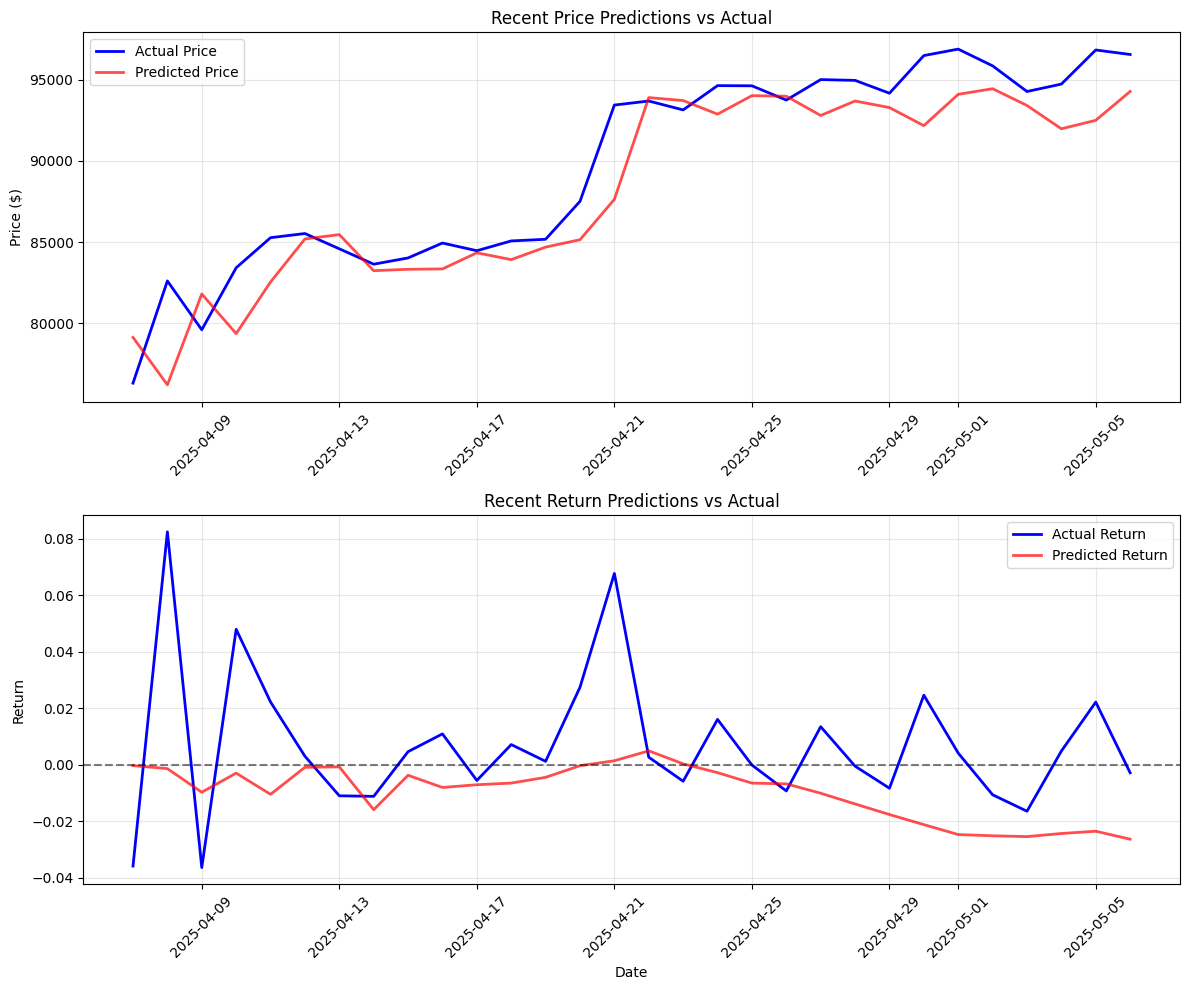

In [19]:
# Initialize the LSTM predictor
lstm_predictor = BitcoinLSTMPredictor(df_daily)

# Engineer features
df_processed = lstm_predictor.engineer_features()

# Prepare data for LSTM training
lstm_predictor.prepare_data(test_size=0.2, val_size=0.1)

# Train models
return_hist, dir_hist = lstm_predictor.train_models(epochs=100, batch_size=32)

# Evaluate models
results = lstm_predictor.evaluate_models()

# Make next day prediction
next_day_pred = lstm_predictor.predict_next_day()

# Plot recent predictions
lstm_predictor.plot_predictions(results)


In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid, ParameterSampler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
import optuna
import itertools
import warnings
warnings.filterwarnings('ignore')

class BitcoinLSTMHyperparameterTuner:
    def __init__(self, predictor_instance):
        """
        Initialize with a trained BitcoinLSTMPredictor instance
        """
        self.predictor = predictor_instance
        self.best_params = {}
        self.tuning_results = []
        
    def define_hyperparameter_space(self):
        """Define comprehensive hyperparameter search space"""
        
        # Grid Search Space (for exhaustive search on key parameters)
        self.grid_space = {
            'sequence_length': [15, 30, 60, 90],
            'lstm_units_1': [32, 64, 128],
            'lstm_units_2': [16, 32, 64],
            'dropout_rate': [0.1, 0.2, 0.3, 0.4],
            'learning_rate': [0.001, 0.01, 0.0001],
            'batch_size': [16, 32, 64],
            'dense_units': [8, 16, 32, 64]
        }
        
        # Random Search Space (for broader exploration)
        self.random_space = {
            'sequence_length': [10, 15, 20, 30, 45, 60, 90, 120],
            'lstm_units_1': [16, 32, 48, 64, 96, 128, 192, 256],
            'lstm_units_2': [8, 16, 24, 32, 48, 64, 96, 128],
            'lstm_units_3': [0, 8, 16, 32],  # 0 means no third layer
            'dropout_rate_1': [0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5],
            'dropout_rate_2': [0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5],
            'dropout_rate_dense': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
            'learning_rate': [0.1, 0.01, 0.001, 0.0001, 0.00001],
            'batch_size': [8, 16, 24, 32, 48, 64, 96, 128],
            'dense_units': [4, 8, 16, 24, 32, 48, 64, 96, 128],
            'optimizer': ['adam', 'rmsprop', 'sgd'],
            'activation': ['relu', 'tanh', 'elu', 'selu'],
            'recurrent_activation': ['sigmoid', 'tanh', 'hard_sigmoid'],
            'use_batch_norm': [True, False],
            'regularizer': [None, 'l1', 'l2', 'l1_l2'],
            'regularizer_strength': [0.001, 0.01, 0.1],
            'cell_type': ['LSTM', 'GRU'],
            'bidirectional': [True, False]
        }
        
        # Bayesian Optimization bounds
        self.bayesian_bounds = {
            'sequence_length': (10, 120),
            'lstm_units_1': (16, 256),
            'lstm_units_2': (8, 128),
            'dropout_rate': (0.0, 0.5),
            'learning_rate': (1e-5, 1e-1),
            'batch_size': (8, 128),
            'dense_units': (4, 128)
        }
    
    def build_model_with_params(self, params, input_shape, model_type='return'):
        """Build model with given hyperparameters"""
        model = Sequential()
        
        # Get regularizer
        reg = None
        if params.get('regularizer') == 'l1':
            reg = l1(params.get('regularizer_strength', 0.01))
        elif params.get('regularizer') == 'l2':
            reg = l2(params.get('regularizer_strength', 0.01))
        elif params.get('regularizer') == 'l1_l2':
            reg = l1_l2(l1=params.get('regularizer_strength', 0.01)/2, 
                       l2=params.get('regularizer_strength', 0.01)/2)
        
        # Cell type
        cell_type = params.get('cell_type', 'LSTM')
        if cell_type == 'LSTM':
            CellLayer = LSTM
        elif cell_type == 'GRU':
            CellLayer = GRU
        else:
            CellLayer = SimpleRNN
        
        # First layer
        if params.get('bidirectional', False):
            from tensorflow.keras.layers import Bidirectional
            model.add(Bidirectional(CellLayer(
                params['lstm_units_1'], 
                return_sequences=True,
                input_shape=input_shape,
                recurrent_activation=params.get('recurrent_activation', 'sigmoid'),
                kernel_regularizer=reg,
                recurrent_regularizer=reg
            )))
        else:
            model.add(CellLayer(
                params['lstm_units_1'], 
                return_sequences=True,
                input_shape=input_shape,
                recurrent_activation=params.get('recurrent_activation', 'sigmoid'),
                kernel_regularizer=reg,
                recurrent_regularizer=reg
            ))
        
        model.add(Dropout(params.get('dropout_rate_1', params.get('dropout_rate', 0.2))))
        
        if params.get('use_batch_norm', True):
            model.add(BatchNormalization())
        
        # Second layer
        return_sequences = params.get('lstm_units_3', 0) > 0
        
        if params.get('bidirectional', False):
            model.add(Bidirectional(CellLayer(
                params['lstm_units_2'], 
                return_sequences=return_sequences,
                recurrent_activation=params.get('recurrent_activation', 'sigmoid'),
                kernel_regularizer=reg,
                recurrent_regularizer=reg
            )))
        else:
            model.add(CellLayer(
                params['lstm_units_2'], 
                return_sequences=return_sequences,
                recurrent_activation=params.get('recurrent_activation', 'sigmoid'),
                kernel_regularizer=reg,
                recurrent_regularizer=reg
            ))
        
        model.add(Dropout(params.get('dropout_rate_2', params.get('dropout_rate', 0.2))))
        
        # Optional third layer
        if params.get('lstm_units_3', 0) > 0:
            if params.get('bidirectional', False):
                model.add(Bidirectional(CellLayer(
                    params['lstm_units_3'], 
                    return_sequences=False,
                    recurrent_activation=params.get('recurrent_activation', 'sigmoid'),
                    kernel_regularizer=reg,
                    recurrent_regularizer=reg
                )))
            else:
                model.add(CellLayer(
                    params['lstm_units_3'], 
                    return_sequences=False,
                    recurrent_activation=params.get('recurrent_activation', 'sigmoid'),
                    kernel_regularizer=reg,
                    recurrent_regularizer=reg
                ))
            model.add(Dropout(params.get('dropout_rate_2', params.get('dropout_rate', 0.2))))
        
        # Dense layers
        model.add(Dense(
            params.get('dense_units', 16), 
            activation=params.get('activation', 'relu'),
            kernel_regularizer=reg
        ))
        model.add(Dropout(params.get('dropout_rate_dense', 0.1)))
        
        # Output layer
        if model_type == 'return':
            model.add(Dense(1, activation='tanh'))
        else:  # direction
            model.add(Dense(1, activation='sigmoid'))
        
        # Compile model
        optimizer_name = params.get('optimizer', 'adam')
        lr = params.get('learning_rate', 0.001)
        
        if optimizer_name == 'adam':
            optimizer = Adam(learning_rate=lr)
        elif optimizer_name == 'rmsprop':
            optimizer = RMSprop(learning_rate=lr)
        else:
            optimizer = SGD(learning_rate=lr)
        
        if model_type == 'return':
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        else:
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
        return model
    
    def evaluate_model(self, params, model_type='return', max_epochs=100):
        """Evaluate model with given parameters"""
        try:
            # Prepare data with new sequence length
            old_sequence_length = self.predictor.sequence_length
            self.predictor.sequence_length = params['sequence_length']
            
            # Re-prepare data with new sequence length
            self.predictor.prepare_data()
            
            # Build model
            input_shape = (self.predictor.sequence_length, self.predictor.X_train.shape[2])
            model = self.build_model_with_params(params, input_shape, model_type)
            
            # Callbacks
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True
            )
            
            reduce_lr = ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-7
            )
            
            # Select target based on model type
            if model_type == 'return':
                y_train = self.predictor.y_return_train
                y_val = self.predictor.y_return_val
                y_test = self.predictor.y_return_test
            else:
                y_train = self.predictor.y_dir_train
                y_val = self.predictor.y_dir_val
                y_test = self.predictor.y_dir_test
            
            # Train model
            history = model.fit(
                self.predictor.X_train, y_train,
                validation_data=(self.predictor.X_val, y_val),
                epochs=max_epochs,
                batch_size=params.get('batch_size', 32),
                callbacks=[early_stopping, reduce_lr],
                verbose=0
            )
            
            # Evaluate
            test_loss = model.evaluate(self.predictor.X_test, y_test, verbose=0)
            
            # Get predictions
            predictions = model.predict(self.predictor.X_test, verbose=0)
            
            if model_type == 'return':
                # For return prediction, calculate MSE and MAE
                mse = mean_squared_error(y_test, predictions)
                mae = mean_absolute_error(y_test, predictions)
                score = -mse  # Negative because we want to maximize
                metrics = {'mse': mse, 'mae': mae, 'test_loss': test_loss[0]}
            else:
                # For direction prediction, calculate accuracy
                pred_classes = (predictions > 0.5).astype(int)
                accuracy = accuracy_score(y_test, pred_classes)
                score = accuracy
                metrics = {'accuracy': accuracy, 'test_loss': test_loss[0]}
            
            # Restore original sequence length
            self.predictor.sequence_length = old_sequence_length
            
            return score, metrics, len(history.history['loss'])
            
        except Exception as e:
            print(f"Error evaluating parameters: {e}")
            # Restore original sequence length
            self.predictor.sequence_length = old_sequence_length
            return -np.inf, {}, 0
    
    def grid_search(self, model_type='return', max_combinations=100):
        """Perform grid search on key parameters"""
        print(f"Starting Grid Search for {model_type} model...")
        
        # Create parameter grid
        param_grid = list(ParameterGrid(self.grid_space))
        
        # Limit combinations if too many
        if len(param_grid) > max_combinations:
            param_grid = param_grid[:max_combinations]
            print(f"Limited to {max_combinations} combinations")
        
        best_score = -np.inf
        best_params = None
        results = []
        
        for i, params in enumerate(param_grid):
            print(f"Grid Search {i+1}/{len(param_grid)}: {params}")
            
            score, metrics, epochs = self.evaluate_model(params, model_type)
            
            result = {
                'params': params.copy(),
                'score': score,
                'metrics': metrics,
                'epochs': epochs,
                'method': 'grid_search'
            }
            results.append(result)
            
            if score > best_score:
                best_score = score
                best_params = params.copy()
                print(f"New best score: {best_score:.6f}")
        
        return best_params, best_score, results
    
    def random_search(self, model_type='return', n_trials=50):
        """Perform random search"""
        print(f"Starting Random Search for {model_type} model...")
        
        # Create random parameter samples
        param_samples = list(ParameterSampler(self.random_space, n_trials, random_state=42))
        
        best_score = -np.inf
        best_params = None
        results = []
        
        for i, params in enumerate(param_samples):
            print(f"Random Search {i+1}/{len(param_samples)}: {params}")
            
            score, metrics, epochs = self.evaluate_model(params, model_type)
            
            result = {
                'params': params.copy(),
                'score': score,
                'metrics': metrics,
                'epochs': epochs,
                'method': 'random_search'
            }
            results.append(result)
            
            if score > best_score:
                best_score = score
                best_params = params.copy()
                print(f"New best score: {best_score:.6f}")
        
        return best_params, best_score, results
    
    def bayesian_optimization(self, model_type='return', n_trials=100):
        """Perform Bayesian optimization using Optuna"""
        print(f"Starting Bayesian Optimization for {model_type} model...")
        
        def objective(trial):
            params = {
                'sequence_length': trial.suggest_int('sequence_length', 10, 120),
                'lstm_units_1': trial.suggest_int('lstm_units_1', 16, 256),
                'lstm_units_2': trial.suggest_int('lstm_units_2', 8, 128),
                'lstm_units_3': trial.suggest_int('lstm_units_3', 0, 64),
                'dropout_rate_1': trial.suggest_float('dropout_rate_1', 0.0, 0.5),
                'dropout_rate_2': trial.suggest_float('dropout_rate_2', 0.0, 0.5),
                'dropout_rate_dense': trial.suggest_float('dropout_rate_dense', 0.0, 0.3),
                'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
                'batch_size': trial.suggest_categorical('batch_size', [8, 16, 24, 32, 48, 64, 96, 128]),
                'dense_units': trial.suggest_int('dense_units', 4, 128),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd']),
                'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'elu', 'selu']),
                'recurrent_activation': trial.suggest_categorical('recurrent_activation', ['sigmoid', 'tanh', 'hard_sigmoid']),
                'use_batch_norm': trial.suggest_categorical('use_batch_norm', [True, False]),
                'regularizer': trial.suggest_categorical('regularizer', [None, 'l1', 'l2', 'l1_l2']),
                'regularizer_strength': trial.suggest_float('regularizer_strength', 0.001, 0.1, log=True),
                'cell_type': trial.suggest_categorical('cell_type', ['LSTM', 'GRU']),
                'bidirectional': trial.suggest_categorical('bidirectional', [True, False])
            }
            
            score, metrics, epochs = self.evaluate_model(params, model_type)
            
            # Store additional info
            trial.set_user_attr('metrics', metrics)
            trial.set_user_attr('epochs', epochs)
            
            return score
        
        # Create study
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        # Extract results
        best_params = study.best_params
        best_score = study.best_value
        
        results = []
        for trial in study.trials:
            result = {
                'params': trial.params,
                'score': trial.value if trial.value is not None else -np.inf,
                'metrics': trial.user_attrs.get('metrics', {}),
                'epochs': trial.user_attrs.get('epochs', 0),
                'method': 'bayesian_optimization'
            }
            results.append(result)
        
        return best_params, best_score, results
    
    def comprehensive_tuning(self, model_type='return'):
        """Perform comprehensive hyperparameter tuning"""
        self.define_hyperparameter_space()
        
        all_results = []
        
        # 1. Grid Search (focused)
        print("="*60)
        print("PHASE 1: GRID SEARCH")
        print("="*60)
        grid_best_params, grid_best_score, grid_results = self.grid_search(model_type, max_combinations=50)
        all_results.extend(grid_results)
        
        # 2. Random Search (exploration)
        print("\n" + "="*60)
        print("PHASE 2: RANDOM SEARCH")
        print("="*60)
        random_best_params, random_best_score, random_results = self.random_search(model_type, n_trials=100)
        all_results.extend(random_results)
        
        # 3. Bayesian Optimization (exploitation)
        print("\n" + "="*60)
        print("PHASE 3: BAYESIAN OPTIMIZATION")
        print("="*60)
        bayes_best_params, bayes_best_score, bayes_results = self.bayesian_optimization(model_type, n_trials=150)
        all_results.extend(bayes_results)
        
        # Find overall best
        best_result = max(all_results, key=lambda x: x['score'])
        
        print("\n" + "="*60)
        print(f"COMPREHENSIVE TUNING RESULTS - {model_type.upper()} MODEL")
        print("="*60)
        print(f"Total evaluations: {len(all_results)}")
        print(f"Best score: {best_result['score']:.6f}")
        print(f"Best method: {best_result['method']}")
        print(f"Best parameters:")
        for param, value in best_result['params'].items():
            print(f"  {param}: {value}")
        print(f"Best metrics: {best_result['metrics']}")
        
        # Store results
        self.tuning_results = all_results
        self.best_params[model_type] = best_result['params']
        
        return best_result['params'], best_result['score'], all_results
    
    def analyze_results(self):
        """Analyze tuning results and provide insights"""
        if not self.tuning_results:
            print("No tuning results available. Run comprehensive_tuning first.")
            return
        
        df = pd.DataFrame(self.tuning_results)
        
        print("\n" + "="*60)
        print("HYPERPARAMETER ANALYSIS")
        print("="*60)
        
        # Best results by method
        print("\nBest scores by method:")
        for method in df['method'].unique():
            method_results = df[df['method'] == method]
            best_score = method_results['score'].max()
            print(f"{method}: {best_score:.6f}")
        
        # Parameter importance analysis
        print("\nParameter importance analysis:")
        
        # For each parameter, analyze correlation with performance
        param_importance = {}
        for result in self.tuning_results:
            for param, value in result['params'].items():
                if param not in param_importance:
                    param_importance[param] = []
                param_importance[param].append((value, result['score']))
        
        # Calculate correlations for numerical parameters
        numerical_params = ['sequence_length', 'lstm_units_1', 'lstm_units_2', 'dropout_rate_1', 
                          'dropout_rate_2', 'learning_rate', 'batch_size', 'dense_units']
        
        for param in numerical_params:
            if param in param_importance:
                values = [x[0] for x in param_importance[param]]
                scores = [x[1] for x in param_importance[param]]
                if len(set(values)) > 1:  # Only if there's variation
                    correlation = np.corrcoef(values, scores)[0, 1]
                    print(f"{param}: correlation = {correlation:.3f}")
        
        # Best value ranges for top parameters
        print("\nOptimal parameter ranges (top 10% results):")
        top_results = df.nlargest(max(1, len(df) // 10), 'score')
        
        for param in numerical_params:
            if param in top_results.iloc[0]['params']:
                param_values = [result['params'][param] for _, result in top_results.iterrows() 
                              if param in result['params']]
                if param_values:
                    print(f"{param}: {min(param_values):.4f} - {max(param_values):.4f} "
                          f"(median: {np.median(param_values):.4f})")
        
        return df
    
    def tune_both_models(self):
        """Tune both return and direction models"""
        print("Starting comprehensive tuning for both models...")
        
        # Tune return model
        return_params, return_score, return_results = self.comprehensive_tuning('return')
        
        # Tune direction model
        direction_params, direction_score, direction_results = self.comprehensive_tuning('direction')
        
        # Analyze results
        self.analyze_results()
        
        return {
            'return_model': {
                'best_params': return_params,
                'best_score': return_score,
                'results': return_results
            },
            'direction_model': {
                'best_params': direction_params,
                'best_score': direction_score,
                'results': direction_results
            }
        }


# Usage example:

# Assuming you have a trained BitcoinLSTMPredictor instance
predictor = BitcoinLSTMPredictor(df_daily)
predictor.engineer_features()
predictor.prepare_data()

# Create tuner
tuner = BitcoinLSTMHyperparameterTuner(predictor)

# Run comprehensive tuning
results = tuner.tune_both_models()

# The best parameters will be stored in tuner.best_params
print("Best parameters for return model:", tuner.best_params['return'])
print("Best parameters for direction model:", tuner.best_params['direction'])


1045
Processed 1045 data points with 53 features
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vader_ma_7', 'article_count_norm', 'funding_rate', 'funding_rate_ma', 'momentum_5', 'momentum_10', 'day_sin', 'day_cos']
Training sequences: 710
Validation sequences: 101
Test sequences: 204
Features per timestep: 27
Last date in dataset: 2025-05-06 00:00:00
Starting comprehensive tuning for both models...
PHASE 1: GRID SEARCH
Starting Grid Search for return model...
Limited to 50 combinations
Grid Search 1/50: {'batch_size': 16, 'dense_units': 8, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'lstm_units_1': 32, 'lstm_units_2': 16, 'sequence_length': 15}
Using 27 features: ['high_close_

[I 2025-07-08 12:04:54,380] A new study created in memory with name: no-name-a60b4685-bd47-4b17-ac7e-950e9f5e4eb8



PHASE 3: BAYESIAN OPTIMIZATION
Starting Bayesian Optimization for return model...


  0%|          | 0/150 [00:00<?, ?it/s]

Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vader_ma_7', 'article_count_norm', 'funding_rate', 'funding_rate_ma', 'momentum_5', 'momentum_10', 'day_sin', 'day_cos']
Training sequences: 647
Validation sequences: 92
Test sequences: 186
Features per timestep: 27
Last date in dataset: 2025-05-06 00:00:00


Best trial: 0. Best value: -0.0102034:   1%|          | 1/150 [00:34<1:25:02, 34.25s/it]

[I 2025-07-08 12:05:28,684] Trial 0 finished with value: -0.010203434510674785 and parameters: {'sequence_length': 120, 'lstm_units_1': 131, 'lstm_units_2': 51, 'lstm_units_3': 38, 'dropout_rate_1': 0.12470325616824474, 'dropout_rate_2': 0.23675578359054472, 'dropout_rate_dense': 0.06652187885374632, 'learning_rate': 0.0009210205557801225, 'batch_size': 48, 'dense_units': 17, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': False, 'regularizer': None, 'regularizer_strength': 0.0022981698180201972, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 0 with value: -0.010203434510674785.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader

Best trial: 1. Best value: -0.00800546:   1%|▏         | 2/150 [00:47<53:57, 21.87s/it]  

[I 2025-07-08 12:05:41,893] Trial 1 finished with value: -0.008005463216588132 and parameters: {'sequence_length': 24, 'lstm_units_1': 35, 'lstm_units_2': 53, 'lstm_units_3': 45, 'dropout_rate_1': 0.11583422269877952, 'dropout_rate_2': 0.05982025643703026, 'dropout_rate_dense': 0.10778728297534948, 'learning_rate': 0.06611307714827304, 'batch_size': 32, 'dense_units': 127, 'optimizer': 'sgd', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.04026775827867137, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vad

Best trial: 1. Best value: -0.00800546:   2%|▏         | 3/150 [00:54<37:05, 15.14s/it]

[I 2025-07-08 12:05:49,023] Trial 2 finished with value: -0.4028892346187065 and parameters: {'sequence_length': 13, 'lstm_units_1': 169, 'lstm_units_2': 56, 'lstm_units_3': 29, 'dropout_rate_1': 0.09441393333622072, 'dropout_rate_2': 0.0025701852004822445, 'dropout_rate_dense': 0.010900251772480196, 'learning_rate': 1.7659454436887427e-05, 'batch_size': 16, 'dense_units': 44, 'optimizer': 'sgd', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': None, 'regularizer_strength': 0.011581077223871306, 'cell_type': 'GRU', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 1. Best value: -0.00800546:   3%|▎         | 4/150 [01:30<56:25, 23.19s/it]

[I 2025-07-08 12:06:24,546] Trial 3 finished with value: -0.00820673898612296 and parameters: {'sequence_length': 45, 'lstm_units_1': 56, 'lstm_units_2': 13, 'lstm_units_3': 59, 'dropout_rate_1': 0.36373375312807404, 'dropout_rate_2': 0.4396442030377667, 'dropout_rate_dense': 0.06387358447292174, 'learning_rate': 0.08566609263771191, 'batch_size': 96, 'dense_units': 22, 'optimizer': 'sgd', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.023502766791201175, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vader_ma

Best trial: 1. Best value: -0.00800546:   3%|▎         | 5/150 [02:07<1:08:31, 28.35s/it]

[I 2025-07-08 12:07:02,058] Trial 4 finished with value: -0.12743304192641217 and parameters: {'sequence_length': 54, 'lstm_units_1': 123, 'lstm_units_2': 26, 'lstm_units_3': 56, 'dropout_rate_1': 0.006321912420142406, 'dropout_rate_2': 0.21590992509103685, 'dropout_rate_dense': 0.07618306679044397, 'learning_rate': 6.383631694995373e-05, 'batch_size': 64, 'dense_units': 80, 'optimizer': 'sgd', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1', 'regularizer_strength': 0.025628337608259597, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 1. Best value: -0.00800546:   4%|▍         | 6/150 [06:39<4:26:40, 111.11s/it]

[I 2025-07-08 12:11:33,826] Trial 5 finished with value: -0.008441383058261292 and parameters: {'sequence_length': 93, 'lstm_units_1': 76, 'lstm_units_2': 119, 'lstm_units_3': 15, 'dropout_rate_1': 0.41364852883073505, 'dropout_rate_2': 0.07310441247262767, 'dropout_rate_dense': 0.2980885191888453, 'learning_rate': 0.002413222155738307, 'batch_size': 8, 'dense_units': 10, 'optimizer': 'sgd', 'activation': 'selu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.03669506862294249, 'cell_type': 'GRU', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'va

Best trial: 1. Best value: -0.00800546:   5%|▍         | 7/150 [06:56<3:11:27, 80.33s/it] 

[I 2025-07-08 12:11:50,780] Trial 6 finished with value: -0.008063823417343347 and parameters: {'sequence_length': 11, 'lstm_units_1': 25, 'lstm_units_2': 60, 'lstm_units_3': 55, 'dropout_rate_1': 0.48045927953272294, 'dropout_rate_2': 0.2523949505845927, 'dropout_rate_dense': 0.24867872169025965, 'learning_rate': 4.271840187663704e-05, 'batch_size': 24, 'dense_units': 52, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.002184382362005391, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 1. Best value: -0.00800546:   5%|▌         | 8/150 [07:59<2:57:06, 74.83s/it]

[I 2025-07-08 12:12:53,838] Trial 7 finished with value: -0.01094771812163592 and parameters: {'sequence_length': 26, 'lstm_units_1': 44, 'lstm_units_2': 52, 'lstm_units_3': 41, 'dropout_rate_1': 0.1354780525550197, 'dropout_rate_2': 0.47004615691320883, 'dropout_rate_dense': 0.2590508069863916, 'learning_rate': 8.435763708421701e-05, 'batch_size': 8, 'dense_units': 60, 'optimizer': 'sgd', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.001275101432910686, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vader_

Best trial: 1. Best value: -0.00800546:   6%|▌         | 9/150 [08:16<2:13:45, 56.92s/it]

[I 2025-07-08 12:13:11,377] Trial 8 finished with value: -0.008561291621018536 and parameters: {'sequence_length': 22, 'lstm_units_1': 25, 'lstm_units_2': 64, 'lstm_units_3': 1, 'dropout_rate_1': 0.17097174977815383, 'dropout_rate_2': 0.08433137118959977, 'dropout_rate_dense': 0.2221208809565587, 'learning_rate': 5.1777262512542705e-05, 'batch_size': 48, 'dense_units': 125, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': False, 'regularizer': None, 'regularizer_strength': 0.06379113930859774, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 1. Best value: -0.00800546:   7%|▋         | 10/150 [09:09<2:09:56, 55.69s/it]

[I 2025-07-08 12:14:04,307] Trial 9 finished with value: -0.059794219400956 and parameters: {'sequence_length': 47, 'lstm_units_1': 28, 'lstm_units_2': 124, 'lstm_units_3': 29, 'dropout_rate_1': 0.42959000091435373, 'dropout_rate_2': 0.3387482070949451, 'dropout_rate_dense': 0.07687557716792244, 'learning_rate': 8.611127975552847e-05, 'batch_size': 64, 'dense_units': 97, 'optimizer': 'sgd', 'activation': 'elu', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': False, 'regularizer': 'l1', 'regularizer_strength': 0.08781419159001598, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 1. Best value: -0.00800546:   7%|▋         | 11/150 [12:12<3:38:44, 94.42s/it]

[I 2025-07-08 12:17:06,555] Trial 10 finished with value: -0.008311879581183644 and parameters: {'sequence_length': 75, 'lstm_units_1': 251, 'lstm_units_2': 99, 'lstm_units_3': 45, 'dropout_rate_1': 0.24859154006404496, 'dropout_rate_2': 0.1429377521139686, 'dropout_rate_dense': 0.1832718230998293, 'learning_rate': 0.04018588630257803, 'batch_size': 32, 'dense_units': 123, 'optimizer': 'rmsprop', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.006165836848488365, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 1. Best value: -0.00800546:   8%|▊         | 12/150 [12:41<2:51:53, 74.74s/it]

[I 2025-07-08 12:17:36,265] Trial 11 finished with value: -0.008071784722276609 and parameters: {'sequence_length': 10, 'lstm_units_1': 88, 'lstm_units_2': 86, 'lstm_units_3': 64, 'dropout_rate_1': 0.29985280466776665, 'dropout_rate_2': 0.3287523112817009, 'dropout_rate_dense': 0.1404571397073854, 'learning_rate': 0.00712112455273791, 'batch_size': 24, 'dense_units': 47, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.004418918366935688, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3

Best trial: 1. Best value: -0.00800546:   9%|▊         | 13/150 [13:22<2:27:02, 64.40s/it]

[I 2025-07-08 12:18:16,881] Trial 12 finished with value: -0.008092706449848192 and parameters: {'sequence_length': 31, 'lstm_units_1': 182, 'lstm_units_2': 35, 'lstm_units_3': 49, 'dropout_rate_1': 0.49261839782221095, 'dropout_rate_2': 0.32011686168278575, 'dropout_rate_dense': 0.13755475077093623, 'learning_rate': 0.00046946816842179155, 'batch_size': 32, 'dense_units': 94, 'optimizer': 'rmsprop', 'activation': 'elu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0010141783008679702, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vad

Best trial: 1. Best value: -0.00800546:   9%|▉         | 14/150 [13:56<2:05:12, 55.24s/it]

[I 2025-07-08 12:18:50,958] Trial 13 finished with value: -0.008580544084032754 and parameters: {'sequence_length': 34, 'lstm_units_1': 91, 'lstm_units_2': 79, 'lstm_units_3': 52, 'dropout_rate_1': 0.22927826003647178, 'dropout_rate_2': 0.16425345998648821, 'dropout_rate_dense': 0.1878649241967459, 'learning_rate': 0.008520478789302108, 'batch_size': 128, 'dense_units': 77, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.012328634508669896, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 1. Best value: -0.00800546:  10%|█         | 15/150 [14:58<2:09:03, 57.36s/it]

[I 2025-07-08 12:19:53,225] Trial 14 finished with value: -0.008338433428092323 and parameters: {'sequence_length': 75, 'lstm_units_1': 16, 'lstm_units_2': 40, 'lstm_units_3': 36, 'dropout_rate_1': 0.027709162188152878, 'dropout_rate_2': 0.29961151834974964, 'dropout_rate_dense': 0.12565357033933167, 'learning_rate': 0.0003358122518888749, 'batch_size': 24, 'dense_units': 36, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0037727454199397515, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vad

Best trial: 1. Best value: -0.00800546:  11%|█         | 16/150 [15:41<1:58:29, 53.05s/it]

[I 2025-07-08 12:20:36,286] Trial 15 finished with value: -0.05250001395626919 and parameters: {'sequence_length': 38, 'lstm_units_1': 69, 'lstm_units_2': 72, 'lstm_units_3': 21, 'dropout_rate_1': 0.32987618700006416, 'dropout_rate_2': 0.40119167784617277, 'dropout_rate_dense': 0.2367273613935466, 'learning_rate': 1.0980126533735546e-05, 'batch_size': 32, 'dense_units': 103, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0022637273069569972, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 1. Best value: -0.00800546:  11%|█▏        | 17/150 [16:54<2:10:23, 58.82s/it]

[I 2025-07-08 12:21:48,514] Trial 16 finished with value: -0.008259738181026257 and parameters: {'sequence_length': 59, 'lstm_units_1': 104, 'lstm_units_2': 90, 'lstm_units_3': 49, 'dropout_rate_1': 0.19752468813652374, 'dropout_rate_2': 0.1750316709746247, 'dropout_rate_dense': 0.2987169215482972, 'learning_rate': 0.017385345803944074, 'batch_size': 24, 'dense_units': 69, 'optimizer': 'rmsprop', 'activation': 'relu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.04708853691552102, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 1. Best value: -0.00800546:  12%|█▏        | 18/150 [18:05<2:17:44, 62.61s/it]

[I 2025-07-08 12:22:59,943] Trial 17 finished with value: -0.008105789371845883 and parameters: {'sequence_length': 18, 'lstm_units_1': 170, 'lstm_units_2': 104, 'lstm_units_3': 58, 'dropout_rate_1': 0.06392886234731382, 'dropout_rate_2': 0.0012211522024214716, 'dropout_rate_dense': 0.17907109085267375, 'learning_rate': 0.0026443557859739887, 'batch_size': 16, 'dense_units': 57, 'optimizer': 'sgd', 'activation': 'selu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.02027236043441393, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 1. Best value: -0.00800546:  13%|█▎        | 19/150 [20:04<2:53:29, 79.47s/it]

[I 2025-07-08 12:24:58,676] Trial 18 finished with value: -0.008486248041683665 and parameters: {'sequence_length': 98, 'lstm_units_1': 231, 'lstm_units_2': 17, 'lstm_units_3': 44, 'dropout_rate_1': 0.4873267625668059, 'dropout_rate_2': 0.1109292910662592, 'dropout_rate_dense': 0.1085990653052718, 'learning_rate': 0.0002262648079620795, 'batch_size': 96, 'dense_units': 29, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l1', 'regularizer_strength': 0.0059907753674750125, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 1. Best value: -0.00800546:  13%|█▎        | 20/150 [20:14<2:07:23, 58.80s/it]

[I 2025-07-08 12:25:09,295] Trial 19 finished with value: -0.23537507203706928 and parameters: {'sequence_length': 11, 'lstm_units_1': 48, 'lstm_units_2': 41, 'lstm_units_3': 63, 'dropout_rate_1': 0.3803342818280248, 'dropout_rate_2': 0.25086546588737013, 'dropout_rate_dense': 0.018943253654986975, 'learning_rate': 0.09219299273937001, 'batch_size': 128, 'dense_units': 85, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0020102453401862736, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader

Best trial: 1. Best value: -0.00800546:  14%|█▍        | 21/150 [22:49<3:08:00, 87.45s/it]

[I 2025-07-08 12:27:43,546] Trial 20 finished with value: -0.00922997195183 and parameters: {'sequence_length': 67, 'lstm_units_1': 199, 'lstm_units_2': 66, 'lstm_units_3': 34, 'dropout_rate_1': 0.2746262248810979, 'dropout_rate_2': 0.3916808132400046, 'dropout_rate_dense': 0.20806527797599916, 'learning_rate': 0.0019177117876160185, 'batch_size': 24, 'dense_units': 112, 'optimizer': 'sgd', 'activation': 'elu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.01709822033185326, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'va

Best trial: 1. Best value: -0.00800546:  15%|█▍        | 22/150 [23:18<2:29:20, 70.00s/it]

[I 2025-07-08 12:28:12,859] Trial 21 finished with value: -0.008105237334889492 and parameters: {'sequence_length': 12, 'lstm_units_1': 101, 'lstm_units_2': 82, 'lstm_units_3': 64, 'dropout_rate_1': 0.3016740059713244, 'dropout_rate_2': 0.2676251748356397, 'dropout_rate_dense': 0.15882788043436977, 'learning_rate': 0.008497986653664072, 'batch_size': 24, 'dense_units': 47, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.004924995593750999, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 1. Best value: -0.00800546:  15%|█▌        | 23/150 [24:07<2:14:49, 63.70s/it]

[I 2025-07-08 12:29:01,862] Trial 22 finished with value: -0.008078488086062287 and parameters: {'sequence_length': 26, 'lstm_units_1': 72, 'lstm_units_2': 89, 'lstm_units_3': 55, 'dropout_rate_1': 0.1897481291767965, 'dropout_rate_2': 0.36877606576774336, 'dropout_rate_dense': 0.11578623006523199, 'learning_rate': 0.022160547309166893, 'batch_size': 24, 'dense_units': 49, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0038776239151192896, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 1. Best value: -0.00800546:  16%|█▌        | 24/150 [24:19<1:40:58, 48.08s/it]

[I 2025-07-08 12:29:13,515] Trial 23 finished with value: -0.008117159535152647 and parameters: {'sequence_length': 20, 'lstm_units_1': 40, 'lstm_units_2': 61, 'lstm_units_3': 48, 'dropout_rate_1': 0.3233789735101188, 'dropout_rate_2': 0.20914559445619438, 'dropout_rate_dense': 0.15416852349310436, 'learning_rate': 0.0051387784987028525, 'batch_size': 32, 'dense_units': 68, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.008757472676140956, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 1. Best value: -0.00800546:  17%|█▋        | 25/150 [24:51<1:30:25, 43.40s/it]

[I 2025-07-08 12:29:45,987] Trial 24 finished with value: -0.008062580652291916 and parameters: {'sequence_length': 10, 'lstm_units_1': 60, 'lstm_units_2': 72, 'lstm_units_3': 64, 'dropout_rate_1': 0.42337994865752565, 'dropout_rate_2': 0.29294541744678804, 'dropout_rate_dense': 0.10046341204026918, 'learning_rate': 0.03415026700748613, 'batch_size': 24, 'dense_units': 38, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.003024808481832102, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 1. Best value: -0.00800546:  17%|█▋        | 26/150 [25:54<1:42:01, 49.37s/it]

[I 2025-07-08 12:30:49,292] Trial 25 finished with value: -0.00817371813849021 and parameters: {'sequence_length': 41, 'lstm_units_1': 61, 'lstm_units_2': 73, 'lstm_units_3': 52, 'dropout_rate_1': 0.4294371293175807, 'dropout_rate_2': 0.2574987288565317, 'dropout_rate_dense': 0.09936660183575187, 'learning_rate': 0.03367584183843523, 'batch_size': 24, 'dense_units': 33, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0028042795337748874, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 1. Best value: -0.00800546:  18%|█▊        | 27/150 [26:36<1:36:35, 47.12s/it]

[I 2025-07-08 12:31:31,163] Trial 26 finished with value: -0.008091685871400961 and parameters: {'sequence_length': 31, 'lstm_units_1': 39, 'lstm_units_2': 45, 'lstm_units_3': 57, 'dropout_rate_1': 0.4441031249816852, 'dropout_rate_2': 0.2865480150661506, 'dropout_rate_dense': 0.041215606287615295, 'learning_rate': 0.043164891810406, 'batch_size': 32, 'dense_units': 5, 'optimizer': 'rmsprop', 'activation': 'selu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': False, 'regularizer': 'l1', 'regularizer_strength': 0.0015254000058281248, 'cell_type': 'GRU', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 1. Best value: -0.00800546:  19%|█▊        | 28/150 [26:49<1:14:56, 36.86s/it]

[I 2025-07-08 12:31:44,086] Trial 27 finished with value: -0.008097923683671846 and parameters: {'sequence_length': 20, 'lstm_units_1': 16, 'lstm_units_2': 59, 'lstm_units_3': 41, 'dropout_rate_1': 0.4551950118051098, 'dropout_rate_2': 0.04151811756835461, 'dropout_rate_dense': 0.2706000535090544, 'learning_rate': 0.01630450035949622, 'batch_size': 24, 'dense_units': 59, 'optimizer': 'rmsprop', 'activation': 'relu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.003034811178924508, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 1. Best value: -0.00800546:  19%|█▉        | 29/150 [27:03<1:00:22, 29.94s/it]

[I 2025-07-08 12:31:57,874] Trial 28 finished with value: -0.008745888528615988 and parameters: {'sequence_length': 27, 'lstm_units_1': 118, 'lstm_units_2': 99, 'lstm_units_3': 59, 'dropout_rate_1': 0.37940088835174646, 'dropout_rate_2': 0.20846523841477876, 'dropout_rate_dense': 0.09122103781421226, 'learning_rate': 0.0009458990417764602, 'batch_size': 64, 'dense_units': 38, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': True, 'regularizer': None, 'regularizer_strength': 0.007654960804965631, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader

Best trial: 1. Best value: -0.00800546:  20%|██        | 30/150 [28:33<1:36:12, 48.11s/it]

[I 2025-07-08 12:33:28,371] Trial 29 finished with value: -0.16332695016784662 and parameters: {'sequence_length': 97, 'lstm_units_1': 135, 'lstm_units_2': 31, 'lstm_units_3': 53, 'dropout_rate_1': 0.13370422495227266, 'dropout_rate_2': 0.12194473324893665, 'dropout_rate_dense': 0.05405306147789512, 'learning_rate': 3.427102367538283e-05, 'batch_size': 48, 'dense_units': 21, 'optimizer': 'sgd', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': None, 'regularizer_strength': 0.0017741866196395908, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 1. Best value: -0.00800546:  21%|██        | 31/150 [35:39<5:20:07, 161.41s/it]

[I 2025-07-08 12:40:34,142] Trial 30 finished with value: -0.008422866787813656 and parameters: {'sequence_length': 108, 'lstm_units_1': 152, 'lstm_units_2': 52, 'lstm_units_3': 41, 'dropout_rate_1': 0.4699893970658884, 'dropout_rate_2': 0.2277113829011209, 'dropout_rate_dense': 0.038332618317460564, 'learning_rate': 0.06287893409134006, 'batch_size': 8, 'dense_units': 113, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.09845913645944566, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 1. Best value: -0.00800546:  21%|██▏       | 32/150 [36:07<3:58:53, 121.47s/it]

[I 2025-07-08 12:41:02,410] Trial 31 finished with value: -0.008066565598237927 and parameters: {'sequence_length': 10, 'lstm_units_1': 84, 'lstm_units_2': 79, 'lstm_units_3': 62, 'dropout_rate_1': 0.35009872080455295, 'dropout_rate_2': 0.3455311160187219, 'dropout_rate_dense': 0.13285125393769637, 'learning_rate': 0.007191674956450951, 'batch_size': 24, 'dense_units': 53, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.004122140657482751, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 1. Best value: -0.00800546:  22%|██▏       | 33/150 [36:47<3:08:47, 96.81s/it] 

[I 2025-07-08 12:41:41,703] Trial 32 finished with value: -0.008074794700093983 and parameters: {'sequence_length': 17, 'lstm_units_1': 34, 'lstm_units_2': 75, 'lstm_units_3': 61, 'dropout_rate_1': 0.40706641850105757, 'dropout_rate_2': 0.35889587112482296, 'dropout_rate_dense': 0.09297322358841667, 'learning_rate': 0.025221671328057606, 'batch_size': 24, 'dense_units': 54, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.002957880323426859, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 1. Best value: -0.00800546:  23%|██▎       | 34/150 [37:20<2:30:18, 77.74s/it]

[I 2025-07-08 12:42:14,949] Trial 33 finished with value: -0.00810201063934104 and parameters: {'sequence_length': 10, 'lstm_units_1': 56, 'lstm_units_2': 57, 'lstm_units_3': 60, 'dropout_rate_1': 0.3688756697355201, 'dropout_rate_2': 0.2944839321663894, 'dropout_rate_dense': 0.16161795481571944, 'learning_rate': 0.00481141941735509, 'batch_size': 16, 'dense_units': 39, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.013119274533078852, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 1. Best value: -0.00800546:  23%|██▎       | 35/150 [37:41<1:56:14, 60.64s/it]

[I 2025-07-08 12:42:35,698] Trial 34 finished with value: -0.008184224920847121 and parameters: {'sequence_length': 16, 'lstm_units_1': 81, 'lstm_units_2': 68, 'lstm_units_3': 55, 'dropout_rate_1': 0.3468140141980282, 'dropout_rate_2': 0.1801132026750643, 'dropout_rate_dense': 0.12572485250642496, 'learning_rate': 0.012580666474662671, 'batch_size': 96, 'dense_units': 26, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0024928706282079907, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_

Best trial: 1. Best value: -0.00800546:  24%|██▍       | 36/150 [38:48<1:58:58, 62.62s/it]

[I 2025-07-08 12:43:42,917] Trial 35 finished with value: -0.00818433113130925 and parameters: {'sequence_length': 49, 'lstm_units_1': 54, 'lstm_units_2': 47, 'lstm_units_3': 49, 'dropout_rate_1': 0.40467550364693916, 'dropout_rate_2': 0.4163996888625681, 'dropout_rate_dense': 0.07155308144996406, 'learning_rate': 0.06871914999544125, 'batch_size': 24, 'dense_units': 77, 'optimizer': 'sgd', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.007020442946563096, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vader_

Best trial: 1. Best value: -0.00800546:  25%|██▍       | 37/150 [38:55<1:26:19, 45.84s/it]

[I 2025-07-08 12:43:49,611] Trial 36 finished with value: -0.014486659539161659 and parameters: {'sequence_length': 24, 'lstm_units_1': 66, 'lstm_units_2': 22, 'lstm_units_3': 61, 'dropout_rate_1': 0.4645112464943678, 'dropout_rate_2': 0.4954612928825735, 'dropout_rate_dense': 0.20191653594205955, 'learning_rate': 0.0018574187906195895, 'batch_size': 24, 'dense_units': 69, 'optimizer': 'sgd', 'activation': 'selu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': False, 'regularizer': None, 'regularizer_strength': 0.0013308385436062956, 'cell_type': 'GRU', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 1. Best value: -0.00800546:  25%|██▌       | 38/150 [39:35<1:22:31, 44.21s/it]

[I 2025-07-08 12:44:30,006] Trial 37 finished with value: -0.008105878896430802 and parameters: {'sequence_length': 40, 'lstm_units_1': 111, 'lstm_units_2': 108, 'lstm_units_3': 21, 'dropout_rate_1': 0.10669628625780839, 'dropout_rate_2': 0.4393056938856446, 'dropout_rate_dense': 0.1680376334950756, 'learning_rate': 0.00016485640713333202, 'batch_size': 48, 'dense_units': 43, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.027064437301320608, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 1. Best value: -0.00800546:  26%|██▌       | 39/150 [39:50<1:05:43, 35.53s/it]

[I 2025-07-08 12:44:45,284] Trial 38 finished with value: -0.022697670899170918 and parameters: {'sequence_length': 15, 'lstm_units_1': 33, 'lstm_units_2': 81, 'lstm_units_3': 45, 'dropout_rate_1': 0.39150105391047896, 'dropout_rate_2': 0.35549525508865765, 'dropout_rate_dense': 0.13866547510092786, 'learning_rate': 0.0006040041956721856, 'batch_size': 128, 'dense_units': 63, 'optimizer': 'sgd', 'activation': 'elu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1', 'regularizer_strength': 0.0033951787259791388, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 1. Best value: -0.00800546:  27%|██▋       | 40/150 [39:58<49:56, 27.24s/it]  

[I 2025-07-08 12:44:53,194] Trial 39 finished with value: -0.2315972813164723 and parameters: {'sequence_length': 33, 'lstm_units_1': 48, 'lstm_units_2': 52, 'lstm_units_3': 53, 'dropout_rate_1': 0.05810430154922875, 'dropout_rate_2': 0.04791815668277152, 'dropout_rate_dense': 0.23716686711445845, 'learning_rate': 0.0492438766722747, 'batch_size': 32, 'dense_units': 12, 'optimizer': 'rmsprop', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.004985686662150217, 'cell_type': 'GRU', 'bidirectional': False}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'va

Best trial: 1. Best value: -0.00800546:  27%|██▋       | 41/150 [41:46<1:33:37, 51.53s/it]

[I 2025-07-08 12:46:41,399] Trial 40 finished with value: -0.01565852182235599 and parameters: {'sequence_length': 24, 'lstm_units_1': 87, 'lstm_units_2': 94, 'lstm_units_3': 57, 'dropout_rate_1': 0.43229857397600274, 'dropout_rate_2': 0.3088813220837274, 'dropout_rate_dense': 0.08144373500832479, 'learning_rate': 2.4699213374887324e-05, 'batch_size': 8, 'dense_units': 52, 'optimizer': 'sgd', 'activation': 'tanh', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.04139406081224793, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 1. Best value: -0.00800546:  28%|██▊       | 42/150 [41:59<1:11:33, 39.75s/it]

[I 2025-07-08 12:46:53,676] Trial 41 finished with value: -0.008815161773438884 and parameters: {'sequence_length': 12, 'lstm_units_1': 93, 'lstm_units_2': 88, 'lstm_units_3': 64, 'dropout_rate_1': 0.2622203640192375, 'dropout_rate_2': 0.3300610043689424, 'dropout_rate_dense': 0.14178964238532527, 'learning_rate': 0.004018807083875457, 'batch_size': 24, 'dense_units': 44, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.004462003560145634, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_

Best trial: 1. Best value: -0.00800546:  29%|██▊       | 43/150 [42:25<1:03:31, 35.62s/it]

[I 2025-07-08 12:47:19,649] Trial 42 finished with value: -0.008066821344657643 and parameters: {'sequence_length': 10, 'lstm_units_1': 27, 'lstm_units_2': 84, 'lstm_units_3': 64, 'dropout_rate_1': 0.302921328987841, 'dropout_rate_2': 0.2772936682879241, 'dropout_rate_dense': 0.12093794897069485, 'learning_rate': 0.010517804566984977, 'batch_size': 24, 'dense_units': 50, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0018485656331682868, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_

Best trial: 1. Best value: -0.00800546:  29%|██▉       | 44/150 [42:48<56:34, 32.02s/it]  

[I 2025-07-08 12:47:43,268] Trial 43 finished with value: -0.008072138750129873 and parameters: {'sequence_length': 19, 'lstm_units_1': 19, 'lstm_units_2': 66, 'lstm_units_3': 0, 'dropout_rate_1': 0.3414025615458032, 'dropout_rate_2': 0.27720977465810565, 'dropout_rate_dense': 0.11570990400847656, 'learning_rate': 0.011950162543324965, 'batch_size': 24, 'dense_units': 30, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0010019951502687585, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 1. Best value: -0.00800546:  30%|███       | 45/150 [43:08<49:28, 28.27s/it]

[I 2025-07-08 12:48:02,800] Trial 44 finished with value: -0.008281280028679401 and parameters: {'sequence_length': 16, 'lstm_units_1': 29, 'lstm_units_2': 78, 'lstm_units_3': 6, 'dropout_rate_1': 0.28789041750432076, 'dropout_rate_2': 0.2387792175185673, 'dropout_rate_dense': 0.10425418374448427, 'learning_rate': 0.028946563092615108, 'batch_size': 64, 'dense_units': 86, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0017736074024107809, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 1 with value: -0.008005463216588132.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 45. Best value: -0.00798881:  31%|███       | 46/150 [43:56<59:32, 34.35s/it]

[I 2025-07-08 12:48:51,317] Trial 45 finished with value: -0.007988810377771076 and parameters: {'sequence_length': 28, 'lstm_units_1': 46, 'lstm_units_2': 71, 'lstm_units_3': 61, 'dropout_rate_1': 0.21727599709685935, 'dropout_rate_2': 0.3795116059653523, 'dropout_rate_dense': 0.12553004260420272, 'learning_rate': 0.09251398246909694, 'batch_size': 24, 'dense_units': 53, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l1_l2', 'regularizer_strength': 0.002244612022779752, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 45 with value: -0.007988810377771076.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 45. Best value: -0.00798881:  31%|███▏      | 47/150 [44:05<45:42, 26.62s/it]

[I 2025-07-08 12:48:59,916] Trial 46 finished with value: -0.2363511501754351 and parameters: {'sequence_length': 29, 'lstm_units_1': 48, 'lstm_units_2': 71, 'lstm_units_3': 61, 'dropout_rate_1': 0.16093552936738614, 'dropout_rate_2': 0.3846434147678412, 'dropout_rate_dense': 0.2777546101866939, 'learning_rate': 0.09117528321173944, 'batch_size': 16, 'dense_units': 62, 'optimizer': 'rmsprop', 'activation': 'selu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': None, 'regularizer_strength': 0.002466848234233651, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 45 with value: -0.007988810377771076.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 47. Best value: -0.00797458:  32%|███▏      | 48/150 [44:17<37:43, 22.19s/it]

[I 2025-07-08 12:49:11,765] Trial 47 finished with value: -0.007974579513883865 and parameters: {'sequence_length': 23, 'lstm_units_1': 75, 'lstm_units_2': 62, 'lstm_units_3': 55, 'dropout_rate_1': 0.21391047596813975, 'dropout_rate_2': 0.3310918107876664, 'dropout_rate_dense': 0.14870524800933685, 'learning_rate': 0.04954169654022332, 'batch_size': 96, 'dense_units': 72, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.06256870128158706, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 47. Best value: -0.00797458:  33%|███▎      | 49/150 [44:47<41:25, 24.61s/it]

[I 2025-07-08 12:49:42,006] Trial 48 finished with value: -0.008105989714022458 and parameters: {'sequence_length': 36, 'lstm_units_1': 74, 'lstm_units_2': 62, 'lstm_units_3': 51, 'dropout_rate_1': 0.23517137006332428, 'dropout_rate_2': 0.31578502925837515, 'dropout_rate_dense': 0.1674010858017123, 'learning_rate': 0.05497355084924239, 'batch_size': 96, 'dense_units': 97, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.06496584658768892, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 47. Best value: -0.00797458:  33%|███▎      | 50/150 [45:11<40:46, 24.47s/it]

[I 2025-07-08 12:50:06,148] Trial 49 finished with value: -0.008182804868529481 and parameters: {'sequence_length': 49, 'lstm_units_1': 60, 'lstm_units_2': 47, 'lstm_units_3': 47, 'dropout_rate_1': 0.2166964094664624, 'dropout_rate_2': 0.41790471107849747, 'dropout_rate_dense': 0.08709949424231674, 'learning_rate': 0.036158565595201864, 'batch_size': 96, 'dense_units': 118, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1', 'regularizer_strength': 0.06712584756004315, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 47. Best value: -0.00797458:  34%|███▍      | 51/150 [45:25<34:53, 21.15s/it]

Error evaluating parameters: Input contains NaN.
[I 2025-07-08 12:50:19,561] Trial 50 finished with value: -inf and parameters: {'sequence_length': 56, 'lstm_units_1': 150, 'lstm_units_2': 55, 'lstm_units_3': 30, 'dropout_rate_1': 0.17774780913934424, 'dropout_rate_2': 0.375807723680202, 'dropout_rate_dense': 0.06471312575345853, 'learning_rate': 0.09924261740709463, 'batch_size': 96, 'dense_units': 15, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.053139699912825904, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'vol

Best trial: 47. Best value: -0.00797458:  35%|███▍      | 52/150 [46:08<45:35, 27.92s/it]

[I 2025-07-08 12:51:03,271] Trial 51 finished with value: -0.008063290065817543 and parameters: {'sequence_length': 22, 'lstm_units_1': 40, 'lstm_units_2': 70, 'lstm_units_3': 55, 'dropout_rate_1': 0.15240122846098467, 'dropout_rate_2': 0.34461682241611535, 'dropout_rate_dense': 0.1343844518123808, 'learning_rate': 0.01740543806170507, 'batch_size': 32, 'dense_units': 73, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.02961053488510509, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 47. Best value: -0.00797458:  35%|███▌      | 53/150 [46:42<47:59, 29.69s/it]

[I 2025-07-08 12:51:37,085] Trial 52 finished with value: -0.008060581535368419 and parameters: {'sequence_length': 22, 'lstm_units_1': 41, 'lstm_units_2': 64, 'lstm_units_3': 55, 'dropout_rate_1': 0.1519607564377603, 'dropout_rate_2': 0.33949106862652556, 'dropout_rate_dense': 0.14716018441494805, 'learning_rate': 0.022221697429541193, 'batch_size': 32, 'dense_units': 128, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.032361066701960095, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 47. Best value: -0.00797458:  36%|███▌      | 54/150 [47:35<58:35, 36.62s/it]

[I 2025-07-08 12:52:29,876] Trial 53 finished with value: -0.008149215685564358 and parameters: {'sequence_length': 43, 'lstm_units_1': 42, 'lstm_units_2': 70, 'lstm_units_3': 56, 'dropout_rate_1': 0.15405217246302116, 'dropout_rate_2': 0.338163828873688, 'dropout_rate_dense': 0.14700959749731712, 'learning_rate': 0.016358948331604395, 'batch_size': 32, 'dense_units': 126, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.03003268285072138, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 47. Best value: -0.00797458:  37%|███▋      | 55/150 [47:54<49:32, 31.29s/it]

[I 2025-07-08 12:52:48,741] Trial 54 finished with value: -0.008006030747388433 and parameters: {'sequence_length': 29, 'lstm_units_1': 54, 'lstm_units_2': 65, 'lstm_units_3': 59, 'dropout_rate_1': 0.09896916908195735, 'dropout_rate_2': 0.4547731582565852, 'dropout_rate_dense': 0.17755759843277605, 'learning_rate': 0.06523102357067305, 'batch_size': 32, 'dense_units': 119, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.034952054415022804, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 47. Best value: -0.00797458:  37%|███▋      | 56/150 [48:46<58:37, 37.42s/it]

[I 2025-07-08 12:53:40,444] Trial 55 finished with value: -0.008163671684193073 and parameters: {'sequence_length': 36, 'lstm_units_1': 65, 'lstm_units_2': 64, 'lstm_units_3': 59, 'dropout_rate_1': 0.10796980502486447, 'dropout_rate_2': 0.45606411572585087, 'dropout_rate_dense': 0.1790829413905306, 'learning_rate': 0.05724391328524898, 'batch_size': 32, 'dense_units': 121, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.03509875786149434, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 47. Best value: -0.00797458:  38%|███▊      | 57/150 [49:24<58:28, 37.72s/it]

[I 2025-07-08 12:54:18,885] Trial 56 finished with value: -0.008003913685292317 and parameters: {'sequence_length': 28, 'lstm_units_1': 51, 'lstm_units_2': 57, 'lstm_units_3': 38, 'dropout_rate_1': 0.08310029823464449, 'dropout_rate_2': 0.49583695854454485, 'dropout_rate_dense': 0.19549518423428847, 'learning_rate': 0.026415397685709132, 'batch_size': 32, 'dense_units': 107, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.02119907110015225, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 47. Best value: -0.00797458:  39%|███▊      | 58/150 [49:44<49:38, 32.38s/it]

[I 2025-07-08 12:54:38,793] Trial 57 finished with value: -0.008017274153277519 and parameters: {'sequence_length': 29, 'lstm_units_1': 49, 'lstm_units_2': 40, 'lstm_units_3': 38, 'dropout_rate_1': 0.0747614843021854, 'dropout_rate_2': 0.49696343649342967, 'dropout_rate_dense': 0.19844932289544862, 'learning_rate': 0.06508109222937505, 'batch_size': 32, 'dense_units': 107, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.022078027106625358, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 47. Best value: -0.00797458:  39%|███▉      | 59/150 [50:29<54:48, 36.14s/it]

[I 2025-07-08 12:55:23,714] Trial 58 finished with value: -0.008081798896466983 and parameters: {'sequence_length': 30, 'lstm_units_1': 52, 'lstm_units_2': 36, 'lstm_units_3': 38, 'dropout_rate_1': 0.07849607986338278, 'dropout_rate_2': 0.4929538332594206, 'dropout_rate_dense': 0.19707687109742397, 'learning_rate': 0.07389256912970618, 'batch_size': 32, 'dense_units': 106, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.02193669303771354, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 47. Best value: -0.00797458:  40%|████      | 60/150 [50:50<47:24, 31.61s/it]

[I 2025-07-08 12:55:44,736] Trial 59 finished with value: -0.008796802174804193 and parameters: {'sequence_length': 44, 'lstm_units_1': 75, 'lstm_units_2': 42, 'lstm_units_3': 33, 'dropout_rate_1': 0.009508807860333146, 'dropout_rate_2': 0.4757126853038561, 'dropout_rate_dense': 0.2135568548463343, 'learning_rate': 0.04698275026583763, 'batch_size': 32, 'dense_units': 105, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.017663157202860113, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 47. Best value: -0.00797458:  41%|████      | 61/150 [52:32<1:18:10, 52.70s/it]

[I 2025-07-08 12:57:26,656] Trial 60 finished with value: -0.2366139283723106 and parameters: {'sequence_length': 78, 'lstm_units_1': 23, 'lstm_units_2': 30, 'lstm_units_3': 37, 'dropout_rate_1': 0.04924368881450633, 'dropout_rate_2': 0.44505389126602635, 'dropout_rate_dense': 0.18979444218784638, 'learning_rate': 0.07991557439919209, 'batch_size': 32, 'dense_units': 115, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.07776423572948062, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 47. Best value: -0.00797458:  41%|████▏     | 62/150 [53:09<1:10:34, 48.12s/it]

[I 2025-07-08 12:58:04,087] Trial 61 finished with value: -0.008056425360482785 and parameters: {'sequence_length': 26, 'lstm_units_1': 34, 'lstm_units_2': 55, 'lstm_units_3': 43, 'dropout_rate_1': 0.09582197695310504, 'dropout_rate_2': 0.4771981226375604, 'dropout_rate_dense': 0.21796691961819017, 'learning_rate': 0.023177255978042953, 'batch_size': 32, 'dense_units': 128, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.053494236976395854, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 47. Best value: -0.00797458:  42%|████▏     | 63/150 [53:45<1:04:36, 44.56s/it]

[I 2025-07-08 12:58:40,336] Trial 62 finished with value: -0.00802375179344052 and parameters: {'sequence_length': 27, 'lstm_units_1': 29, 'lstm_units_2': 56, 'lstm_units_3': 42, 'dropout_rate_1': 0.08681084584637919, 'dropout_rate_2': 0.47662633702029295, 'dropout_rate_dense': 0.22389371205705852, 'learning_rate': 0.029729345595797804, 'batch_size': 32, 'dense_units': 109, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.05190469636070013, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 47. Best value: -0.00797458:  43%|████▎     | 64/150 [54:28<1:02:58, 43.94s/it]

[I 2025-07-08 12:59:22,811] Trial 63 finished with value: -0.008089330739189016 and parameters: {'sequence_length': 33, 'lstm_units_1': 52, 'lstm_units_2': 52, 'lstm_units_3': 26, 'dropout_rate_1': 0.03905704699430427, 'dropout_rate_2': 0.45920822845141746, 'dropout_rate_dense': 0.23608522463026618, 'learning_rate': 0.045168461839460314, 'batch_size': 32, 'dense_units': 109, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.04133904963971892, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 47. Best value: -0.00797458:  43%|████▎     | 65/150 [55:04<58:55, 41.60s/it]  

[I 2025-07-08 12:59:58,962] Trial 64 finished with value: -0.008090790499973459 and parameters: {'sequence_length': 38, 'lstm_units_1': 25, 'lstm_units_2': 49, 'lstm_units_3': 40, 'dropout_rate_1': 0.08282143061332721, 'dropout_rate_2': 0.429995912524676, 'dropout_rate_dense': 0.2230205575192434, 'learning_rate': 0.03266012822043738, 'batch_size': 32, 'dense_units': 99, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.024389294157525453, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'va

Best trial: 47. Best value: -0.00797458:  44%|████▍     | 66/150 [55:22<48:10, 34.41s/it]

[I 2025-07-08 13:00:16,593] Trial 65 finished with value: -0.00830785296468982 and parameters: {'sequence_length': 28, 'lstm_units_1': 67, 'lstm_units_2': 60, 'lstm_units_3': 35, 'dropout_rate_1': 0.12929754018584677, 'dropout_rate_2': 0.40780601683528306, 'dropout_rate_dense': 0.1702463394574155, 'learning_rate': 0.06530129753022948, 'batch_size': 32, 'dense_units': 120, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0415034695574725, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'va

Best trial: 47. Best value: -0.00797458:  45%|████▍     | 67/150 [55:39<40:30, 29.28s/it]

[I 2025-07-08 13:00:33,903] Trial 66 finished with value: -0.008119575463473278 and parameters: {'sequence_length': 33, 'lstm_units_1': 34, 'lstm_units_2': 36, 'lstm_units_3': 31, 'dropout_rate_1': 0.11468986602160441, 'dropout_rate_2': 0.48294554950425145, 'dropout_rate_dense': 0.19089197754848025, 'learning_rate': 0.037087418920153783, 'batch_size': 128, 'dense_units': 93, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1', 'regularizer_strength': 0.01413165022796974, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 47. Best value: -0.00797458:  45%|████▌     | 68/150 [57:05<1:03:28, 46.44s/it]

[I 2025-07-08 13:02:00,385] Trial 67 finished with value: -0.23679101725837842 and parameters: {'sequence_length': 118, 'lstm_units_1': 100, 'lstm_units_2': 44, 'lstm_units_3': 40, 'dropout_rate_1': 0.06971122384597381, 'dropout_rate_2': 0.46494110284158424, 'dropout_rate_dense': 0.22800529292920316, 'learning_rate': 0.09972064806158022, 'batch_size': 32, 'dense_units': 109, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.052764348966374275, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 47. Best value: -0.00797458:  46%|████▌     | 69/150 [57:28<52:50, 39.14s/it]  

[I 2025-07-08 13:02:22,481] Trial 68 finished with value: -0.008022559526021465 and parameters: {'sequence_length': 24, 'lstm_units_1': 46, 'lstm_units_2': 57, 'lstm_units_3': 46, 'dropout_rate_1': 0.022455883190368883, 'dropout_rate_2': 0.4984539181283602, 'dropout_rate_dense': 0.25248353827686654, 'learning_rate': 0.058161390634082294, 'batch_size': 96, 'dense_units': 116, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.07828609995912848, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 47. Best value: -0.00797458:  47%|████▋     | 70/150 [57:36<39:51, 29.89s/it]

[I 2025-07-08 13:02:30,792] Trial 69 finished with value: -0.03520632461590832 and parameters: {'sequence_length': 22, 'lstm_units_1': 81, 'lstm_units_2': 77, 'lstm_units_3': 47, 'dropout_rate_1': 0.010816157998242829, 'dropout_rate_2': 0.49984919725008564, 'dropout_rate_dense': 0.25091166679967564, 'learning_rate': 0.06654133836452526, 'batch_size': 96, 'dense_units': 116, 'optimizer': 'sgd', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': None, 'regularizer_strength': 0.0187075654809892, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vade

Best trial: 47. Best value: -0.00797458:  47%|████▋     | 71/150 [58:12<41:58, 31.88s/it]

[I 2025-07-08 13:03:07,305] Trial 70 finished with value: -0.008168213962283491 and parameters: {'sequence_length': 47, 'lstm_units_1': 57, 'lstm_units_2': 60, 'lstm_units_3': 51, 'dropout_rate_1': 0.2090197260714452, 'dropout_rate_2': 0.44408567727853354, 'dropout_rate_dense': 0.28587272170118977, 'learning_rate': 0.04492309430394774, 'batch_size': 96, 'dense_units': 124, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.009601133214441865, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader

Best trial: 47. Best value: -0.00797458:  48%|████▊     | 72/150 [58:36<38:03, 29.27s/it]

[I 2025-07-08 13:03:30,502] Trial 71 finished with value: -0.008049206517158807 and parameters: {'sequence_length': 26, 'lstm_units_1': 44, 'lstm_units_2': 58, 'lstm_units_3': 42, 'dropout_rate_1': 0.030668130089791218, 'dropout_rate_2': 0.47986160241338566, 'dropout_rate_dense': 0.2567813760277005, 'learning_rate': 0.03265419258472882, 'batch_size': 96, 'dense_units': 100, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.08519711376830258, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 47. Best value: -0.00797458:  49%|████▊     | 73/150 [59:08<38:40, 30.13s/it]

[I 2025-07-08 13:04:02,643] Trial 72 finished with value: -0.008053985508579362 and parameters: {'sequence_length': 29, 'lstm_units_1': 47, 'lstm_units_2': 39, 'lstm_units_3': 46, 'dropout_rate_1': 0.08599604701782308, 'dropout_rate_2': 0.43182401567126644, 'dropout_rate_dense': 0.20627753059465187, 'learning_rate': 0.026056984894610724, 'batch_size': 48, 'dense_units': 112, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.07278702178010936, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 47. Best value: -0.00797458:  49%|████▉     | 74/150 [59:35<36:56, 29.17s/it]

[I 2025-07-08 13:04:29,553] Trial 73 finished with value: -0.2364413107732931 and parameters: {'sequence_length': 39, 'lstm_units_1': 16, 'lstm_units_2': 55, 'lstm_units_3': 43, 'dropout_rate_1': 0.05131219510878245, 'dropout_rate_2': 0.4560028596156745, 'dropout_rate_dense': 0.18286952498859288, 'learning_rate': 0.058953092399037274, 'batch_size': 64, 'dense_units': 92, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0578805499104581, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vade

Best trial: 47. Best value: -0.00797458:  50%|█████     | 75/150 [1:00:30<46:15, 37.01s/it]

[I 2025-07-08 13:05:24,859] Trial 74 finished with value: -0.008017044976283407 and parameters: {'sequence_length': 24, 'lstm_units_1': 66, 'lstm_units_2': 49, 'lstm_units_3': 36, 'dropout_rate_1': 0.025416511254690757, 'dropout_rate_2': 0.48720120483304635, 'dropout_rate_dense': 0.15425534274729916, 'learning_rate': 0.07646376804222138, 'batch_size': 32, 'dense_units': 109, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.04496379408961106, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 47. Best value: -0.00797458:  51%|█████     | 76/150 [1:00:53<40:30, 32.84s/it]

[I 2025-07-08 13:05:47,981] Trial 75 finished with value: -0.009090657581807472 and parameters: {'sequence_length': 19, 'lstm_units_1': 64, 'lstm_units_2': 50, 'lstm_units_3': 28, 'dropout_rate_1': 0.025563149154623103, 'dropout_rate_2': 0.4965150338506697, 'dropout_rate_dense': 0.15616153951331682, 'learning_rate': 0.07608832483526257, 'batch_size': 8, 'dense_units': 121, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.015309606340291175, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'va

Best trial: 47. Best value: -0.00797458:  51%|█████▏    | 77/150 [1:01:08<33:30, 27.54s/it]

[I 2025-07-08 13:06:03,155] Trial 76 finished with value: -0.008072724794701574 and parameters: {'sequence_length': 14, 'lstm_units_1': 72, 'lstm_units_2': 10, 'lstm_units_3': 36, 'dropout_rate_1': 0.001060785562060726, 'dropout_rate_2': 0.4664979731646805, 'dropout_rate_dense': 0.13077641214340133, 'learning_rate': 0.05126373175342542, 'batch_size': 96, 'dense_units': 102, 'optimizer': 'sgd', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.0453259737548745, 'cell_type': 'GRU', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 47. Best value: -0.00797458:  52%|█████▏    | 78/150 [1:02:35<54:20, 45.28s/it]

[I 2025-07-08 13:07:29,831] Trial 77 finished with value: -0.008015297549885008 and parameters: {'sequence_length': 24, 'lstm_units_1': 225, 'lstm_units_2': 67, 'lstm_units_3': 33, 'dropout_rate_1': 0.03850916193822178, 'dropout_rate_2': 0.3944155842725593, 'dropout_rate_dense': 0.11316697578816873, 'learning_rate': 0.07952489082615341, 'batch_size': 16, 'dense_units': 117, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.011272383258455365, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 47. Best value: -0.00797458:  53%|█████▎    | 79/150 [1:04:40<1:21:50, 69.17s/it]

[I 2025-07-08 13:09:34,730] Trial 78 finished with value: -0.00812427479356186 and parameters: {'sequence_length': 35, 'lstm_units_1': 233, 'lstm_units_2': 67, 'lstm_units_3': 33, 'dropout_rate_1': 0.06987434829332734, 'dropout_rate_2': 0.4024509216192145, 'dropout_rate_dense': 0.10673466997441829, 'learning_rate': 0.07637839574214324, 'batch_size': 16, 'dense_units': 123, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.010525085546688314, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 47. Best value: -0.00797458:  53%|█████▎    | 80/150 [1:08:11<2:10:25, 111.79s/it]

[I 2025-07-08 13:13:05,962] Trial 79 finished with value: -0.008296704339140025 and parameters: {'sequence_length': 64, 'lstm_units_1': 252, 'lstm_units_2': 63, 'lstm_units_3': 26, 'dropout_rate_1': 0.11920818540945795, 'dropout_rate_2': 0.37820231551090433, 'dropout_rate_dense': 0.11326807435462465, 'learning_rate': 0.040417021306898296, 'batch_size': 16, 'dense_units': 82, 'optimizer': 'sgd', 'activation': 'elu', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.021573796349861757, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vade

Best trial: 47. Best value: -0.00797458:  54%|█████▍    | 81/150 [1:09:55<2:05:59, 109.55s/it]

[I 2025-07-08 13:14:50,302] Trial 80 finished with value: -0.008067900784142759 and parameters: {'sequence_length': 31, 'lstm_units_1': 201, 'lstm_units_2': 75, 'lstm_units_3': 35, 'dropout_rate_1': 0.04352755148767736, 'dropout_rate_2': 0.38974158354511235, 'dropout_rate_dense': 0.12300282150471635, 'learning_rate': 0.01839685121422897, 'batch_size': 16, 'dense_units': 89, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1', 'regularizer_strength': 0.035852698583308536, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 47. Best value: -0.00797458:  55%|█████▍    | 82/150 [1:10:45<1:43:40, 91.48s/it] 

[I 2025-07-08 13:15:39,628] Trial 81 finished with value: -0.008017363302513203 and parameters: {'sequence_length': 24, 'lstm_units_1': 182, 'lstm_units_2': 47, 'lstm_units_3': 38, 'dropout_rate_1': 0.026994233639950918, 'dropout_rate_2': 0.419942587296397, 'dropout_rate_dense': 0.17429297905191588, 'learning_rate': 0.08154240999819984, 'batch_size': 32, 'dense_units': 115, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.09739247635948778, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 47. Best value: -0.00797458:  55%|█████▌    | 83/150 [1:11:28<1:26:07, 77.12s/it]

[I 2025-07-08 13:16:23,234] Trial 82 finished with value: -0.008113217704919132 and parameters: {'sequence_length': 19, 'lstm_units_1': 200, 'lstm_units_2': 45, 'lstm_units_3': 38, 'dropout_rate_1': 0.05934411506231789, 'dropout_rate_2': 0.42242257966280766, 'dropout_rate_dense': 0.17417742967768526, 'learning_rate': 0.09839655555700927, 'batch_size': 32, 'dense_units': 113, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.028075266413608052, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3

Best trial: 47. Best value: -0.00797458:  56%|█████▌    | 84/150 [1:11:58<1:09:17, 62.99s/it]

[I 2025-07-08 13:16:53,262] Trial 83 finished with value: -0.008009374598468627 and parameters: {'sequence_length': 24, 'lstm_units_1': 163, 'lstm_units_2': 40, 'lstm_units_3': 32, 'dropout_rate_1': 0.034596577666600584, 'dropout_rate_2': 0.3605713200810374, 'dropout_rate_dense': 0.1978011643226495, 'learning_rate': 0.07760862523229488, 'batch_size': 32, 'dense_units': 119, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.024232170950963878, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 47. Best value: -0.00797458:  57%|█████▋    | 85/150 [1:13:52<1:24:38, 78.13s/it]

[I 2025-07-08 13:18:46,698] Trial 84 finished with value: -0.008366061550605618 and parameters: {'sequence_length': 82, 'lstm_units_1': 223, 'lstm_units_2': 30, 'lstm_units_3': 28, 'dropout_rate_1': 0.10154467558079633, 'dropout_rate_2': 0.3615753272656719, 'dropout_rate_dense': 0.19682752768657857, 'learning_rate': 0.0413618590114605, 'batch_size': 32, 'dense_units': 119, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.025052985624604302, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 47. Best value: -0.00797458:  57%|█████▋    | 86/150 [1:15:19<1:26:24, 81.01s/it]

[I 2025-07-08 13:20:14,433] Trial 85 finished with value: -0.008106184263730004 and parameters: {'sequence_length': 32, 'lstm_units_1': 170, 'lstm_units_2': 39, 'lstm_units_3': 32, 'dropout_rate_1': 0.19072056010003183, 'dropout_rate_2': 0.08674235858554999, 'dropout_rate_dense': 0.1455906625250236, 'learning_rate': 0.05338450998567703, 'batch_size': 16, 'dense_units': 107, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.015746938448904572, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 47. Best value: -0.00797458:  58%|█████▊    | 87/150 [1:15:36<1:04:35, 61.51s/it]

[I 2025-07-08 13:20:30,452] Trial 86 finished with value: -0.00807723761256655 and parameters: {'sequence_length': 14, 'lstm_units_1': 131, 'lstm_units_2': 68, 'lstm_units_3': 22, 'dropout_rate_1': 0.244598124274805, 'dropout_rate_2': 0.019469367677105387, 'dropout_rate_dense': 0.1596756409581718, 'learning_rate': 0.07244092484665098, 'batch_size': 32, 'dense_units': 124, 'optimizer': 'sgd', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': None, 'regularizer_strength': 0.03776918632136013, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vade

Best trial: 47. Best value: -0.00797458:  59%|█████▊    | 88/150 [1:15:59<51:51, 50.19s/it]  

[I 2025-07-08 13:20:54,218] Trial 87 finished with value: -0.008093596543517887 and parameters: {'sequence_length': 17, 'lstm_units_1': 155, 'lstm_units_2': 53, 'lstm_units_3': 58, 'dropout_rate_1': 0.06416552089985843, 'dropout_rate_2': 0.3924571425991123, 'dropout_rate_dense': 0.1550967439734796, 'learning_rate': 0.0012788455165682216, 'batch_size': 128, 'dense_units': 103, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.01920871310173349, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 47. Best value: -0.00797458:  59%|█████▉    | 89/150 [1:16:53<52:06, 51.25s/it]

[I 2025-07-08 13:21:47,959] Trial 88 finished with value: -0.008043575662170984 and parameters: {'sequence_length': 22, 'lstm_units_1': 244, 'lstm_units_2': 23, 'lstm_units_3': 34, 'dropout_rate_1': 0.13529260217785982, 'dropout_rate_2': 0.4533136966168344, 'dropout_rate_dense': 0.21166005842656516, 'learning_rate': 0.08817552956801664, 'batch_size': 32, 'dense_units': 111, 'optimizer': 'adam', 'activation': 'relu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1_l2', 'regularizer_strength': 0.03238571667946383, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 47. Best value: -0.00797458:  60%|██████    | 90/150 [1:17:17<43:12, 43.21s/it]

[I 2025-07-08 13:22:12,409] Trial 89 finished with value: -0.008005432497045026 and parameters: {'sequence_length': 29, 'lstm_units_1': 94, 'lstm_units_2': 126, 'lstm_units_3': 40, 'dropout_rate_1': 0.0763183603907247, 'dropout_rate_2': 0.14971182137608857, 'dropout_rate_dense': 0.19930474098800127, 'learning_rate': 0.057680863875322085, 'batch_size': 48, 'dense_units': 118, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.011691335313530955, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 47. Best value: -0.00797458:  61%|██████    | 91/150 [1:18:16<47:05, 47.89s/it]

[I 2025-07-08 13:23:11,220] Trial 90 finished with value: -0.00816572283900787 and parameters: {'sequence_length': 42, 'lstm_units_1': 94, 'lstm_units_2': 117, 'lstm_units_3': 36, 'dropout_rate_1': 0.0396131442446728, 'dropout_rate_2': 0.12953309766626794, 'dropout_rate_dense': 0.1285489323945452, 'learning_rate': 0.0275863566206749, 'batch_size': 48, 'dense_units': 117, 'optimizer': 'sgd', 'activation': 'elu', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.012782170419119141, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 47. Best value: -0.00797458:  61%|██████▏   | 92/150 [1:18:41<39:33, 40.93s/it]

[I 2025-07-08 13:23:35,898] Trial 91 finished with value: -0.008004685062690005 and parameters: {'sequence_length': 29, 'lstm_units_1': 209, 'lstm_units_2': 110, 'lstm_units_3': 40, 'dropout_rate_1': 0.07514762131867166, 'dropout_rate_2': 0.09132705330427837, 'dropout_rate_dense': 0.20071978422526068, 'learning_rate': 0.06453192572821777, 'batch_size': 48, 'dense_units': 122, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.010995770640090241, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 47. Best value: -0.00797458:  62%|██████▏   | 93/150 [1:19:01<33:03, 34.80s/it]

[I 2025-07-08 13:23:56,417] Trial 92 finished with value: -0.008004911242704183 and parameters: {'sequence_length': 25, 'lstm_units_1': 213, 'lstm_units_2': 121, 'lstm_units_3': 31, 'dropout_rate_1': 0.01630989666574494, 'dropout_rate_2': 0.0956877834178319, 'dropout_rate_dense': 0.16548503419776356, 'learning_rate': 0.052586090024496795, 'batch_size': 48, 'dense_units': 121, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.011604964699318541, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 47. Best value: -0.00797458:  63%|██████▎   | 94/150 [1:19:20<27:56, 29.94s/it]

[I 2025-07-08 13:24:14,989] Trial 93 finished with value: -0.008099006396092507 and parameters: {'sequence_length': 21, 'lstm_units_1': 211, 'lstm_units_2': 128, 'lstm_units_3': 29, 'dropout_rate_1': 0.05435528321665425, 'dropout_rate_2': 0.09208414021894736, 'dropout_rate_dense': 0.1869628364035369, 'learning_rate': 0.047888151967656244, 'batch_size': 48, 'dense_units': 121, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.007577993047300702, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 47. Best value: -0.00797458:  63%|██████▎   | 95/150 [1:19:47<26:34, 28.99s/it]

[I 2025-07-08 13:24:41,778] Trial 94 finished with value: -0.008045176472787501 and parameters: {'sequence_length': 36, 'lstm_units_1': 221, 'lstm_units_2': 108, 'lstm_units_3': 30, 'dropout_rate_1': 0.09838645850925654, 'dropout_rate_2': 0.10220267613458936, 'dropout_rate_dense': 0.20493484637061737, 'learning_rate': 0.03823898163941578, 'batch_size': 48, 'dense_units': 124, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.01150667990089182, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 47 with value: -0.007974579513883865.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 95. Best value: -0.00797458:  64%|██████▍   | 96/150 [1:20:10<24:37, 27.36s/it]

[I 2025-07-08 13:25:05,342] Trial 95 finished with value: -0.007974577651995184 and parameters: {'sequence_length': 27, 'lstm_units_1': 240, 'lstm_units_2': 119, 'lstm_units_3': 40, 'dropout_rate_1': 0.177056896654064, 'dropout_rate_2': 0.062310243829994325, 'dropout_rate_dense': 0.09533792192759646, 'learning_rate': 0.058415735449551934, 'batch_size': 48, 'dense_units': 126, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.009692079515580819, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 95. Best value: -0.00797458:  65%|██████▍   | 97/150 [1:20:45<26:12, 29.66s/it]

[I 2025-07-08 13:25:40,374] Trial 96 finished with value: -0.008008129201577249 and parameters: {'sequence_length': 30, 'lstm_units_1': 242, 'lstm_units_2': 120, 'lstm_units_3': 40, 'dropout_rate_1': 0.21484628608955122, 'dropout_rate_2': 0.0768487787905976, 'dropout_rate_dense': 0.09570871947192683, 'learning_rate': 0.019397943680199273, 'batch_size': 48, 'dense_units': 128, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.00893165309274002, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 95. Best value: -0.00797458:  65%|██████▌   | 98/150 [1:21:04<22:42, 26.19s/it]

[I 2025-07-08 13:25:58,468] Trial 97 finished with value: -0.008025773319825177 and parameters: {'sequence_length': 31, 'lstm_units_1': 243, 'lstm_units_2': 118, 'lstm_units_3': 40, 'dropout_rate_1': 0.22199908926100512, 'dropout_rate_2': 0.07054013200125828, 'dropout_rate_dense': 0.09704067870543946, 'learning_rate': 0.0127252047602528, 'batch_size': 48, 'dense_units': 56, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.009762694957938274, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 95. Best value: -0.00797458:  66%|██████▌   | 99/150 [1:21:55<28:40, 33.74s/it]

[I 2025-07-08 13:26:49,796] Trial 98 finished with value: -0.008042087376807233 and parameters: {'sequence_length': 37, 'lstm_units_1': 239, 'lstm_units_2': 121, 'lstm_units_3': 44, 'dropout_rate_1': 0.17303820007209023, 'dropout_rate_2': 0.0604055515197299, 'dropout_rate_dense': 0.08740541908636926, 'learning_rate': 0.019491740805151665, 'batch_size': 48, 'dense_units': 128, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.005822081075721997, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 95. Best value: -0.00797458:  67%|██████▋   | 100/150 [1:28:47<2:02:46, 147.33s/it]

[I 2025-07-08 13:33:42,197] Trial 99 finished with value: -0.008471756263834642 and parameters: {'sequence_length': 27, 'lstm_units_1': 255, 'lstm_units_2': 113, 'lstm_units_3': 40, 'dropout_rate_1': 0.20316656727532414, 'dropout_rate_2': 0.02651304027108191, 'dropout_rate_dense': 0.07634624986767936, 'learning_rate': 0.023113560648304003, 'batch_size': 48, 'dense_units': 125, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.009164731739214498, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 95. Best value: -0.00797458:  67%|██████▋   | 101/150 [1:38:11<3:42:26, 272.38s/it]

[I 2025-07-08 13:43:06,363] Trial 100 finished with value: -0.008055148168237047 and parameters: {'sequence_length': 34, 'lstm_units_1': 216, 'lstm_units_2': 126, 'lstm_units_3': 62, 'dropout_rate_1': 0.25415044305478884, 'dropout_rate_2': 0.14610211304311566, 'dropout_rate_dense': 0.16575538468623832, 'learning_rate': 0.03561487841366015, 'batch_size': 48, 'dense_units': 127, 'optimizer': 'sgd', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.00818112013131494, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 95. Best value: -0.00797458:  68%|██████▊   | 102/150 [1:38:25<2:35:42, 194.64s/it]

[I 2025-07-08 13:43:19,598] Trial 101 finished with value: -0.25462334555685323 and parameters: {'sequence_length': 26, 'lstm_units_1': 192, 'lstm_units_2': 122, 'lstm_units_3': 49, 'dropout_rate_1': 0.23497896624809117, 'dropout_rate_2': 0.0702095894952551, 'dropout_rate_dense': 0.19232015686396117, 'learning_rate': 0.05203159868997746, 'batch_size': 48, 'dense_units': 122, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.006368323613525241, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 95. Best value: -0.00797458:  69%|██████▊   | 103/150 [1:38:54<1:53:36, 145.04s/it]

[I 2025-07-08 13:43:48,902] Trial 102 finished with value: -0.008007166855129162 and parameters: {'sequence_length': 29, 'lstm_units_1': 208, 'lstm_units_2': 114, 'lstm_units_3': 39, 'dropout_rate_1': 0.1808057550554896, 'dropout_rate_2': 0.050488004471295395, 'dropout_rate_dense': 0.18162698934079202, 'learning_rate': 0.06192617738166089, 'batch_size': 48, 'dense_units': 119, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.014747108689059825, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 95. Best value: -0.00797458:  69%|██████▉   | 104/150 [1:40:06<1:34:29, 123.24s/it]

[I 2025-07-08 13:45:01,291] Trial 103 finished with value: -0.2363511501754351 and parameters: {'sequence_length': 31, 'lstm_units_1': 212, 'lstm_units_2': 114, 'lstm_units_3': 42, 'dropout_rate_1': 0.16392230959912407, 'dropout_rate_2': 0.050350451872031014, 'dropout_rate_dense': 0.18066273515950482, 'learning_rate': 0.06037194980804254, 'batch_size': 48, 'dense_units': 126, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.014638593657293633, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 95. Best value: -0.00797458:  70%|███████   | 105/150 [1:40:39<1:12:09, 96.21s/it] 

[I 2025-07-08 13:45:34,414] Trial 104 finished with value: -0.008004311466203434 and parameters: {'sequence_length': 28, 'lstm_units_1': 236, 'lstm_units_2': 110, 'lstm_units_3': 39, 'dropout_rate_1': 0.1860224234775584, 'dropout_rate_2': 0.019086190107869605, 'dropout_rate_dense': 0.11900225006963698, 'learning_rate': 0.030340625862869546, 'batch_size': 48, 'dense_units': 65, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.016790057303140867, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 95. Best value: -0.00797458:  71%|███████   | 106/150 [1:42:53<1:18:51, 107.54s/it]

[I 2025-07-08 13:47:48,385] Trial 105 finished with value: -0.008022808398720565 and parameters: {'sequence_length': 28, 'lstm_units_1': 235, 'lstm_units_2': 103, 'lstm_units_3': 39, 'dropout_rate_1': 0.14680015620375583, 'dropout_rate_2': 0.01111119568160731, 'dropout_rate_dense': 0.1393657558338271, 'learning_rate': 0.00012852230090050636, 'batch_size': 48, 'dense_units': 74, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.01343653892427005, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 95. Best value: -0.00797458:  71%|███████▏  | 107/150 [1:44:02<1:08:45, 95.95s/it] 

[I 2025-07-08 13:48:57,304] Trial 106 finished with value: -0.008103489081252569 and parameters: {'sequence_length': 20, 'lstm_units_1': 206, 'lstm_units_2': 111, 'lstm_units_3': 45, 'dropout_rate_1': 0.18426662515203823, 'dropout_rate_2': 0.045656929347475964, 'dropout_rate_dense': 0.175378464348783, 'learning_rate': 0.04216327820802405, 'batch_size': 48, 'dense_units': 64, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.01631584375989129, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'va

Best trial: 95. Best value: -0.00797458:  72%|███████▏  | 108/150 [1:44:52<57:21, 81.94s/it]  

[I 2025-07-08 13:49:46,568] Trial 107 finished with value: -0.008370250471084457 and parameters: {'sequence_length': 40, 'lstm_units_1': 229, 'lstm_units_2': 123, 'lstm_units_3': 60, 'dropout_rate_1': 0.1941104635959555, 'dropout_rate_2': 0.028665157226668216, 'dropout_rate_dense': 0.11763384431412233, 'learning_rate': 0.02915259728037458, 'batch_size': 48, 'dense_units': 67, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.01207507608376433, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 95. Best value: -0.00797458:  73%|███████▎  | 109/150 [1:45:08<42:29, 62.19s/it]

[I 2025-07-08 13:50:02,672] Trial 108 finished with value: -0.008066843480337751 and parameters: {'sequence_length': 18, 'lstm_units_1': 188, 'lstm_units_2': 102, 'lstm_units_3': 53, 'dropout_rate_1': 0.1250403009560732, 'dropout_rate_2': 0.036157182360440986, 'dropout_rate_dense': 0.10233015479538238, 'learning_rate': 0.057739113362678764, 'batch_size': 48, 'dense_units': 114, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.01703735432324128, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 95. Best value: -0.00797458:  73%|███████▎  | 110/150 [1:45:37<34:47, 52.19s/it]

[I 2025-07-08 13:50:31,508] Trial 109 finished with value: -0.00804208855238982 and parameters: {'sequence_length': 34, 'lstm_units_1': 217, 'lstm_units_2': 107, 'lstm_units_3': 43, 'dropout_rate_1': 0.20198797000896446, 'dropout_rate_2': 0.05549269237939569, 'dropout_rate_dense': 0.15092025926259575, 'learning_rate': 0.03246505858204791, 'batch_size': 48, 'dense_units': 58, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.010717236659965256, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 95. Best value: -0.00797458:  74%|███████▍  | 111/150 [1:47:17<43:22, 66.73s/it]

[I 2025-07-08 13:52:12,177] Trial 110 finished with value: -0.008126903486611436 and parameters: {'sequence_length': 26, 'lstm_units_1': 79, 'lstm_units_2': 114, 'lstm_units_3': 37, 'dropout_rate_1': 0.11533880272884489, 'dropout_rate_2': 0.11569378820182259, 'dropout_rate_dense': 0.2137251610584067, 'learning_rate': 0.04988998038887149, 'batch_size': 48, 'dense_units': 48, 'optimizer': 'sgd', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.001149882956633309, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'va

Best trial: 95. Best value: -0.00797458:  75%|███████▍  | 112/150 [1:48:03<38:11, 60.31s/it]

[I 2025-07-08 13:52:57,492] Trial 111 finished with value: -0.008005231972541039 and parameters: {'sequence_length': 29, 'lstm_units_1': 246, 'lstm_units_2': 126, 'lstm_units_3': 40, 'dropout_rate_1': 0.21629092792044985, 'dropout_rate_2': 0.08213007418292703, 'dropout_rate_dense': 0.16456569414391733, 'learning_rate': 0.026026373303415652, 'batch_size': 48, 'dense_units': 122, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.008247599618614631, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 95. Best value: -0.00797458:  75%|███████▌  | 113/150 [1:51:16<1:01:43, 100.10s/it]

[I 2025-07-08 13:56:10,444] Trial 112 finished with value: -0.23612066944523086 and parameters: {'sequence_length': 28, 'lstm_units_1': 248, 'lstm_units_2': 126, 'lstm_units_3': 44, 'dropout_rate_1': 0.14308628871079387, 'dropout_rate_2': 0.06715356003675033, 'dropout_rate_dense': 0.16521970945549216, 'learning_rate': 0.06386681347586667, 'batch_size': 48, 'dense_units': 119, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.013835389509170133, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 95. Best value: -0.00797458:  76%|███████▌  | 114/150 [1:52:03<50:36, 84.36s/it]   

[I 2025-07-08 13:56:58,063] Trial 113 finished with value: -0.008077304750029908 and parameters: {'sequence_length': 32, 'lstm_units_1': 228, 'lstm_units_2': 117, 'lstm_units_3': 41, 'dropout_rate_1': 0.22458760108764708, 'dropout_rate_2': 0.10239711867526918, 'dropout_rate_dense': 0.18212666155640314, 'learning_rate': 0.014906920478255826, 'batch_size': 48, 'dense_units': 123, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.008249200987087695, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 95. Best value: -0.00797458:  77%|███████▋  | 115/150 [1:54:17<57:52, 99.23s/it]

[I 2025-07-08 13:59:11,991] Trial 114 finished with value: -0.008015123535882778 and parameters: {'sequence_length': 23, 'lstm_units_1': 57, 'lstm_units_2': 111, 'lstm_units_3': 10, 'dropout_rate_1': 0.18409393281056902, 'dropout_rate_2': 0.18305050878897278, 'dropout_rate_dense': 0.18823795418233044, 'learning_rate': 0.04041513325570135, 'batch_size': 8, 'dense_units': 122, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.010340957089689998, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'v

Best trial: 95. Best value: -0.00797458:  77%|███████▋  | 116/150 [1:54:53<45:26, 80.20s/it]

[I 2025-07-08 13:59:47,786] Trial 115 finished with value: -0.2363511501754351 and parameters: {'sequence_length': 29, 'lstm_units_1': 112, 'lstm_units_2': 124, 'lstm_units_3': 39, 'dropout_rate_1': 0.2683119726520977, 'dropout_rate_2': 0.08165646405280175, 'dropout_rate_dense': 0.17159388614351753, 'learning_rate': 0.09933177254476667, 'batch_size': 48, 'dense_units': 73, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.011944858170412711, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', '

Best trial: 95. Best value: -0.00797458:  78%|███████▊  | 117/150 [1:55:36<37:55, 68.95s/it]

[I 2025-07-08 14:00:30,487] Trial 116 finished with value: -0.00804231280034295 and parameters: {'sequence_length': 38, 'lstm_units_1': 237, 'lstm_units_2': 95, 'lstm_units_3': 57, 'dropout_rate_1': 0.16935942747773847, 'dropout_rate_2': 0.09546418618902613, 'dropout_rate_dense': 0.16206395853968766, 'learning_rate': 0.026395465386591085, 'batch_size': 64, 'dense_units': 61, 'optimizer': 'rmsprop', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.01830412609191588, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 95. Best value: -0.00797458:  79%|███████▊  | 118/150 [1:56:23<33:23, 62.60s/it]

[I 2025-07-08 14:01:18,267] Trial 117 finished with value: -0.00797734827354275 and parameters: {'sequence_length': 26, 'lstm_units_1': 249, 'lstm_units_2': 128, 'lstm_units_3': 37, 'dropout_rate_1': 0.24132148636228465, 'dropout_rate_2': 0.0009176467615940459, 'dropout_rate_dense': 0.13467921247497733, 'learning_rate': 0.06602826388445258, 'batch_size': 48, 'dense_units': 117, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.02007053173471777, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 95. Best value: -0.00797458:  79%|███████▉  | 119/150 [1:56:45<25:56, 50.22s/it]

[I 2025-07-08 14:01:39,613] Trial 118 finished with value: -0.008080816191974685 and parameters: {'sequence_length': 20, 'lstm_units_1': 248, 'lstm_units_2': 128, 'lstm_units_3': 35, 'dropout_rate_1': 0.09136240767690801, 'dropout_rate_2': 0.007472835761242018, 'dropout_rate_dense': 0.12526931507466316, 'learning_rate': 0.04739721409985861, 'batch_size': 48, 'dense_units': 44, 'optimizer': 'adam', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.022653205105459265, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 95. Best value: -0.00797458:  80%|████████  | 120/150 [1:57:10<21:22, 42.75s/it]

[I 2025-07-08 14:02:04,923] Trial 119 finished with value: -0.007975044725082816 and parameters: {'sequence_length': 26, 'lstm_units_1': 247, 'lstm_units_2': 126, 'lstm_units_3': 41, 'dropout_rate_1': 0.24084006683873435, 'dropout_rate_2': 0.0008076768314687344, 'dropout_rate_dense': 0.002056963389185873, 'learning_rate': 0.00915547204261104, 'batch_size': 48, 'dense_units': 117, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.006642651142459012, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_

Best trial: 95. Best value: -0.00797458:  81%|████████  | 121/150 [1:57:30<17:22, 35.94s/it]

[I 2025-07-08 14:02:24,972] Trial 120 finished with value: -0.008067929612940639 and parameters: {'sequence_length': 16, 'lstm_units_1': 256, 'lstm_units_2': 125, 'lstm_units_3': 37, 'dropout_rate_1': 0.24536452973027678, 'dropout_rate_2': 0.03412456965831005, 'dropout_rate_dense': 0.05496591534708265, 'learning_rate': 0.02186386671505463, 'batch_size': 48, 'dense_units': 115, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'sigmoid', 'use_batch_norm': True, 'regularizer': 'l2', 'regularizer_strength': 0.005392887532415593, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3

Best trial: 95. Best value: -0.00797458:  81%|████████▏ | 122/150 [1:57:51<14:43, 31.56s/it]

[I 2025-07-08 14:02:46,303] Trial 121 finished with value: -0.007974659744681877 and parameters: {'sequence_length': 26, 'lstm_units_1': 247, 'lstm_units_2': 119, 'lstm_units_3': 42, 'dropout_rate_1': 0.22996104712824292, 'dropout_rate_2': 0.0031232769126760484, 'dropout_rate_dense': 0.014820693251497794, 'learning_rate': 0.010536724929115233, 'batch_size': 48, 'dense_units': 125, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.019688698674700925, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 95. Best value: -0.00797458:  82%|████████▏ | 123/150 [1:58:15<13:10, 29.26s/it]

[I 2025-07-08 14:03:10,212] Trial 122 finished with value: -0.007975583357740177 and parameters: {'sequence_length': 26, 'lstm_units_1': 250, 'lstm_units_2': 118, 'lstm_units_3': 42, 'dropout_rate_1': 0.2333480764737437, 'dropout_rate_2': 0.016900926992281396, 'dropout_rate_dense': 0.014135607316264459, 'learning_rate': 0.01039086493125733, 'batch_size': 48, 'dense_units': 125, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.019941820936602083, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 95. Best value: -0.00797458:  83%|████████▎ | 124/150 [1:58:38<11:52, 27.39s/it]

[I 2025-07-08 14:03:33,229] Trial 123 finished with value: -0.007975275677059825 and parameters: {'sequence_length': 26, 'lstm_units_1': 248, 'lstm_units_2': 120, 'lstm_units_3': 42, 'dropout_rate_1': 0.2831529024448508, 'dropout_rate_2': 0.00599480004062318, 'dropout_rate_dense': 0.0019606794891826734, 'learning_rate': 0.009236928278210073, 'batch_size': 48, 'dense_units': 125, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.020211446132499453, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3

Best trial: 95. Best value: -0.00797458:  83%|████████▎ | 125/150 [1:59:05<11:16, 27.07s/it]

[I 2025-07-08 14:03:59,549] Trial 124 finished with value: -0.008004878560201207 and parameters: {'sequence_length': 25, 'lstm_units_1': 248, 'lstm_units_2': 119, 'lstm_units_3': 42, 'dropout_rate_1': 0.292460068793795, 'dropout_rate_2': 0.01735484722949402, 'dropout_rate_dense': 0.0013113406258496753, 'learning_rate': 0.006769758761250233, 'batch_size': 48, 'dense_units': 126, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.007364364901350392, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 95. Best value: -0.00797458:  84%|████████▍ | 126/150 [1:59:34<11:05, 27.73s/it]

[I 2025-07-08 14:04:28,837] Trial 125 finished with value: -0.008006865935073137 and parameters: {'sequence_length': 25, 'lstm_units_1': 252, 'lstm_units_2': 119, 'lstm_units_3': 43, 'dropout_rate_1': 0.2954142280473155, 'dropout_rate_2': 0.013859444280272314, 'dropout_rate_dense': 0.0019126413803572718, 'learning_rate': 0.006045785846767595, 'batch_size': 48, 'dense_units': 125, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.006783235174496778, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_

Best trial: 95. Best value: -0.00797458:  85%|████████▍ | 127/150 [2:00:00<10:26, 27.23s/it]

[I 2025-07-08 14:04:54,903] Trial 126 finished with value: -0.007977911452574872 and parameters: {'sequence_length': 26, 'lstm_units_1': 237, 'lstm_units_2': 117, 'lstm_units_3': 45, 'dropout_rate_1': 0.27972380730634494, 'dropout_rate_2': 0.0009387623896457316, 'dropout_rate_dense': 0.021377088041574798, 'learning_rate': 0.008152367727262555, 'batch_size': 48, 'dense_units': 111, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.020245167974601682, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 95. Best value: -0.00797458:  85%|████████▌ | 128/150 [2:00:54<12:58, 35.41s/it]

[I 2025-07-08 14:05:49,378] Trial 127 finished with value: -0.008117963201048487 and parameters: {'sequence_length': 20, 'lstm_units_1': 239, 'lstm_units_2': 116, 'lstm_units_3': 47, 'dropout_rate_1': 0.31569299608266926, 'dropout_rate_2': 0.0031075672238336845, 'dropout_rate_dense': 0.019864797724788972, 'learning_rate': 0.010272023806283326, 'batch_size': 48, 'dense_units': 126, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.019611916690231043, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 95. Best value: -0.00797458:  86%|████████▌ | 129/150 [2:01:20<11:22, 32.49s/it]

[I 2025-07-08 14:06:15,050] Trial 128 finished with value: -0.007974578153938677 and parameters: {'sequence_length': 27, 'lstm_units_1': 249, 'lstm_units_2': 111, 'lstm_units_3': 42, 'dropout_rate_1': 0.2643659463410898, 'dropout_rate_2': 0.021049649418984014, 'dropout_rate_dense': 0.016794029505023025, 'learning_rate': 0.008002893474229096, 'batch_size': 48, 'dense_units': 111, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.020808610736791622, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_

Best trial: 95. Best value: -0.00797458:  87%|████████▋ | 130/150 [2:01:43<09:54, 29.75s/it]

[I 2025-07-08 14:06:38,409] Trial 129 finished with value: -0.008015497859734247 and parameters: {'sequence_length': 22, 'lstm_units_1': 232, 'lstm_units_2': 112, 'lstm_units_3': 46, 'dropout_rate_1': 0.2795217979081794, 'dropout_rate_2': 0.0010157267482339685, 'dropout_rate_dense': 0.023354927599679567, 'learning_rate': 0.0039231752903797126, 'batch_size': 48, 'dense_units': 112, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.0266710516323614, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_

Best trial: 95. Best value: -0.00797458:  87%|████████▋ | 131/150 [2:02:19<09:55, 31.33s/it]

[I 2025-07-08 14:07:13,440] Trial 130 finished with value: -0.00818219251578975 and parameters: {'sequence_length': 35, 'lstm_units_1': 242, 'lstm_units_2': 110, 'lstm_units_3': 41, 'dropout_rate_1': 0.25705615249183206, 'dropout_rate_2': 0.022584579953241608, 'dropout_rate_dense': 0.011738487361682091, 'learning_rate': 0.008534990376016375, 'batch_size': 24, 'dense_units': 110, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.020750224442746185, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_

Best trial: 95. Best value: -0.00797458:  88%|████████▊ | 132/150 [2:02:46<09:03, 30.17s/it]

[I 2025-07-08 14:07:40,915] Trial 131 finished with value: -0.008024515446775713 and parameters: {'sequence_length': 22, 'lstm_units_1': 249, 'lstm_units_2': 107, 'lstm_units_3': 42, 'dropout_rate_1': 0.2769820321823263, 'dropout_rate_2': 0.037129849034369625, 'dropout_rate_dense': 0.0011970371130107377, 'learning_rate': 0.007110058350754278, 'batch_size': 48, 'dense_units': 105, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.017449671031087948, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 95. Best value: -0.00797458:  89%|████████▊ | 133/150 [2:03:21<09:00, 31.77s/it]

[I 2025-07-08 14:08:16,402] Trial 132 finished with value: -0.008018528285589766 and parameters: {'sequence_length': 26, 'lstm_units_1': 253, 'lstm_units_2': 116, 'lstm_units_3': 44, 'dropout_rate_1': 0.23737308126913148, 'dropout_rate_2': 0.017625556795761416, 'dropout_rate_dense': 0.028446231721492875, 'learning_rate': 0.0044942952666323045, 'batch_size': 48, 'dense_units': 116, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.023122940800532097, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 95. Best value: -0.00797458:  89%|████████▉ | 134/150 [2:04:43<12:25, 46.60s/it]

[I 2025-07-08 14:09:37,611] Trial 133 finished with value: -0.008089403691736611 and parameters: {'sequence_length': 32, 'lstm_units_1': 238, 'lstm_units_2': 119, 'lstm_units_3': 42, 'dropout_rate_1': 0.27103710791618074, 'dropout_rate_2': 0.00011634497576840791, 'dropout_rate_dense': 0.008503287486530536, 'learning_rate': 0.0032337247840176766, 'batch_size': 48, 'dense_units': 113, 'optimizer': 'adam', 'activation': 'elu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.02070561140011065, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_m

Best trial: 95. Best value: -0.00797458:  90%|█████████ | 135/150 [2:05:11<10:14, 40.97s/it]

[I 2025-07-08 14:10:05,460] Trial 134 finished with value: -0.007985374304621004 and parameters: {'sequence_length': 27, 'lstm_units_1': 247, 'lstm_units_2': 115, 'lstm_units_3': 44, 'dropout_rate_1': 0.2303129137291043, 'dropout_rate_2': 0.010785204858885974, 'dropout_rate_dense': 0.032695887024527144, 'learning_rate': 0.009036959171469901, 'batch_size': 48, 'dense_units': 51, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.026102030931799955, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3

Best trial: 95. Best value: -0.00797458:  91%|█████████ | 136/150 [2:05:52<09:34, 41.07s/it]

[I 2025-07-08 14:10:46,748] Trial 135 finished with value: -0.008090003365434988 and parameters: {'sequence_length': 33, 'lstm_units_1': 256, 'lstm_units_2': 123, 'lstm_units_3': 50, 'dropout_rate_1': 0.227934704204816, 'dropout_rate_2': 0.025168813358428455, 'dropout_rate_dense': 0.033421306315436494, 'learning_rate': 0.009267301234008029, 'batch_size': 48, 'dense_units': 52, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.025024884644136366, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 95. Best value: -0.00797458:  91%|█████████▏| 137/150 [2:06:48<09:51, 45.47s/it]

[I 2025-07-08 14:11:42,486] Trial 136 finished with value: -0.00801782067606878 and parameters: {'sequence_length': 27, 'lstm_units_1': 244, 'lstm_units_2': 100, 'lstm_units_3': 45, 'dropout_rate_1': 0.24753361958741663, 'dropout_rate_2': 0.011169611756951659, 'dropout_rate_dense': 0.012496904508781475, 'learning_rate': 0.0129494562983837, 'batch_size': 128, 'dense_units': 40, 'optimizer': 'rmsprop', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l1', 'regularizer_strength': 0.016363376492929866, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma

Best trial: 95. Best value: -0.00797458:  92%|█████████▏| 138/150 [2:08:15<11:37, 58.15s/it]

[I 2025-07-08 14:13:10,216] Trial 137 finished with value: -0.008068493744504522 and parameters: {'sequence_length': 18, 'lstm_units_1': 227, 'lstm_units_2': 109, 'lstm_units_3': 38, 'dropout_rate_1': 0.30948375343862256, 'dropout_rate_2': 0.03190050060023901, 'dropout_rate_dense': 0.04526656567034792, 'learning_rate': 0.010434711737917303, 'batch_size': 48, 'dense_units': 65, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.028723295643301786, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 95. Best value: -0.00797458:  93%|█████████▎| 139/150 [2:08:33<08:24, 45.87s/it]

[I 2025-07-08 14:13:27,439] Trial 138 finished with value: -0.008010242777172156 and parameters: {'sequence_length': 23, 'lstm_units_1': 234, 'lstm_units_2': 121, 'lstm_units_3': 44, 'dropout_rate_1': 0.25941454898895266, 'dropout_rate_2': 0.04005694473046095, 'dropout_rate_dense': 0.026378786158444224, 'learning_rate': 0.008434511813636534, 'batch_size': 48, 'dense_units': 54, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'hard_sigmoid', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.01872567594740147, 'cell_type': 'LSTM', 'bidirectional': False}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'va

Best trial: 95. Best value: -0.00797458:  93%|█████████▎| 140/150 [2:09:24<07:55, 47.60s/it]

[I 2025-07-08 14:14:19,063] Trial 139 finished with value: -0.010098490068482471 and parameters: {'sequence_length': 86, 'lstm_units_1': 242, 'lstm_units_2': 115, 'lstm_units_3': 48, 'dropout_rate_1': 0.283325840014279, 'dropout_rate_2': 0.009377606953272919, 'dropout_rate_dense': 0.015170431154472355, 'learning_rate': 0.00580251840531695, 'batch_size': 96, 'dense_units': 50, 'optimizer': 'adam', 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_batch_norm': False, 'regularizer': None, 'regularizer_strength': 0.020214373830975938, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_

Best trial: 95. Best value: -0.00797458:  94%|█████████▍| 141/150 [2:10:09<07:01, 46.81s/it]

[I 2025-07-08 14:15:04,053] Trial 140 finished with value: -0.007974601090533422 and parameters: {'sequence_length': 27, 'lstm_units_1': 250, 'lstm_units_2': 105, 'lstm_units_3': 39, 'dropout_rate_1': 0.24071505275522606, 'dropout_rate_2': 0.021309246347402732, 'dropout_rate_dense': 0.034343912345223916, 'learning_rate': 0.014348081355763317, 'batch_size': 8, 'dense_units': 71, 'optimizer': 'adam', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.03217232681400403, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 95. Best value: -0.00797458:  95%|█████████▍| 142/150 [2:11:14<06:57, 52.15s/it]

[I 2025-07-08 14:16:08,640] Trial 141 finished with value: -0.007977366374032704 and parameters: {'sequence_length': 27, 'lstm_units_1': 252, 'lstm_units_2': 104, 'lstm_units_3': 39, 'dropout_rate_1': 0.2380527821486302, 'dropout_rate_2': 9.571000768397904e-05, 'dropout_rate_dense': 0.0339979803224669, 'learning_rate': 0.01233455615673635, 'batch_size': 8, 'dense_units': 78, 'optimizer': 'adam', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.025778110815185287, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 95. Best value: -0.00797458:  95%|█████████▌| 143/150 [2:12:43<07:24, 63.43s/it]

[I 2025-07-08 14:17:38,412] Trial 142 finished with value: -0.008372020411689393 and parameters: {'sequence_length': 69, 'lstm_units_1': 249, 'lstm_units_2': 105, 'lstm_units_3': 39, 'dropout_rate_1': 0.23849627914126684, 'dropout_rate_2': 0.021288592098486596, 'dropout_rate_dense': 0.03379102292230508, 'learning_rate': 0.013781680701489385, 'batch_size': 8, 'dense_units': 80, 'optimizer': 'adam', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.02709822335379765, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 95. Best value: -0.00797458:  96%|█████████▌| 144/150 [2:13:47<06:20, 63.40s/it]

[I 2025-07-08 14:18:41,730] Trial 143 finished with value: -0.007975326879510917 and parameters: {'sequence_length': 27, 'lstm_units_1': 252, 'lstm_units_2': 117, 'lstm_units_3': 37, 'dropout_rate_1': 0.20804064550678414, 'dropout_rate_2': 0.009188817460221666, 'dropout_rate_dense': 0.04834454487641995, 'learning_rate': 0.011462039158453886, 'batch_size': 8, 'dense_units': 73, 'optimizer': 'adam', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.022405165272534933, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3'

Best trial: 95. Best value: -0.00797458:  97%|█████████▋| 145/150 [2:14:30<04:46, 57.33s/it]

[I 2025-07-08 14:19:24,903] Trial 144 finished with value: -0.00812317679924445 and parameters: {'sequence_length': 21, 'lstm_units_1': 252, 'lstm_units_2': 117, 'lstm_units_3': 37, 'dropout_rate_1': 0.2648970033215812, 'dropout_rate_2': 0.000977930250820963, 'dropout_rate_dense': 0.04484647212311986, 'learning_rate': 0.011004590653411766, 'batch_size': 8, 'dense_units': 75, 'optimizer': 'adam', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.031722999400004746, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 95. Best value: -0.00797458:  97%|█████████▋| 146/150 [2:15:51<04:17, 64.45s/it]

[I 2025-07-08 14:20:45,965] Trial 145 finished with value: -0.008010198829024 and parameters: {'sequence_length': 31, 'lstm_units_1': 256, 'lstm_units_2': 93, 'lstm_units_3': 35, 'dropout_rate_1': 0.2097031920851204, 'dropout_rate_2': 0.011622271794966806, 'dropout_rate_dense': 0.019427327982506785, 'learning_rate': 0.01590511727868412, 'batch_size': 8, 'dense_units': 69, 'optimizer': 'adam', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.022988483529063602, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'va

Best trial: 95. Best value: -0.00797458:  98%|█████████▊| 147/150 [2:17:55<04:07, 82.40s/it]

[I 2025-07-08 14:22:50,249] Trial 146 finished with value: -0.007983195685434742 and parameters: {'sequence_length': 26, 'lstm_units_1': 245, 'lstm_units_2': 123, 'lstm_units_3': 41, 'dropout_rate_1': 0.23183109485520165, 'dropout_rate_2': 0.029296782002594467, 'dropout_rate_dense': 0.0569800224889496, 'learning_rate': 0.008967025284516154, 'batch_size': 8, 'dense_units': 70, 'optimizer': 'adam', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.02565143686731511, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 

Best trial: 95. Best value: -0.00797458:  99%|█████████▊| 148/150 [2:19:34<02:54, 87.28s/it]

[I 2025-07-08 14:24:28,929] Trial 147 finished with value: -0.00800564152396645 and parameters: {'sequence_length': 25, 'lstm_units_1': 246, 'lstm_units_2': 128, 'lstm_units_3': 43, 'dropout_rate_1': 0.22755380592117125, 'dropout_rate_2': 0.029273170338343472, 'dropout_rate_dense': 0.036359901959169064, 'learning_rate': 0.008199030713510413, 'batch_size': 8, 'dense_units': 79, 'optimizer': 'rmsprop', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.0301067384613251, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3

Best trial: 95. Best value: -0.00797458:  99%|█████████▉| 149/150 [2:20:23<01:15, 75.86s/it]

[I 2025-07-08 14:25:18,124] Trial 148 finished with value: -0.008005827317030803 and parameters: {'sequence_length': 23, 'lstm_units_1': 239, 'lstm_units_2': 122, 'lstm_units_3': 41, 'dropout_rate_1': 0.2509790723072898, 'dropout_rate_2': 0.04313494117549428, 'dropout_rate_dense': 0.057647591442487184, 'learning_rate': 0.006057931664249651, 'batch_size': 8, 'dense_units': 70, 'optimizer': 'adam', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.024738398298983784, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3',

Best trial: 95. Best value: -0.00797458: 100%|██████████| 150/150 [2:22:22<00:00, 56.95s/it]


[I 2025-07-08 14:27:17,330] Trial 149 finished with value: -0.00808427106294186 and parameters: {'sequence_length': 13, 'lstm_units_1': 249, 'lstm_units_2': 124, 'lstm_units_3': 46, 'dropout_rate_1': 0.2357923327622996, 'dropout_rate_2': 0.008279231739032628, 'dropout_rate_dense': 0.006085485619973224, 'learning_rate': 0.005413791445434552, 'batch_size': 8, 'dense_units': 76, 'optimizer': 'adam', 'activation': 'selu', 'recurrent_activation': 'tanh', 'use_batch_norm': False, 'regularizer': 'l2', 'regularizer_strength': 0.026457882790429484, 'cell_type': 'LSTM', 'bidirectional': True}. Best is trial 95 with value: -0.007974577651995184.

COMPREHENSIVE TUNING RESULTS - RETURN MODEL
Total evaluations: 300
Best score: -0.007947
Best method: grid_search
Best parameters:
  batch_size: 16
  dense_units: 8
  dropout_rate: 0.1
  learning_rate: 0.01
  lstm_units_1: 64
  lstm_units_2: 16
  sequence_length: 30
Best metrics: {'mse': 0.007947153529160693, 'mae': 0.06260370296555019, 'test_loss': 0.00

KeyboardInterrupt: 

In [37]:
class TunedBitcoinLSTMPredictor:
    def __init__(self, df_daily):
        self.df = df_daily.copy()
        self.price_scaler = MinMaxScaler(feature_range=(0, 1))
        self.feature_scaler = RobustScaler()
        self.target_scaler = MinMaxScaler(feature_range=(0, 1))
        # Optimized hyperparameters from comprehensive tuning
        self.sequence_length = 30
        self.lstm_units_1 = 64
        self.lstm_units_2 = 16
        self.dense_units = 8
        self.dropout_rate = 0.1
        self.learning_rate = 0.01
        self.batch_size = 16
        self.price_model = None
        self.direction_model = None
        self.feature_names = None
        
    def engineer_features(self):
        """Create technical indicators and features"""
        df = self.df.copy()
        
        # Ensure we have enough data
        if len(df) < 100:
            raise ValueError("Need at least 100 data points for proper LSTM training")
        
        # Basic price ratios (more stable than absolute differences)
        df['high_close_ratio'] = df['high'] / df['close']
        df['low_close_ratio'] = df['low'] / df['close']
        df['open_close_ratio'] = df['open'] / df['close']
        df['volume_avg_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
        
        # Returns instead of absolute prices (more stationary)
        df['returns_1d'] = df['close'].pct_change()
        df['returns_3d'] = df['close'].pct_change(3)
        df['returns_7d'] = df['close'].pct_change(7)
        df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
        
        # Moving average ratios
        for window in [5, 10, 20]:
            df[f'ma_{window}'] = df['close'].rolling(window).mean()
            df[f'price_ma_{window}_ratio'] = df['close'] / df[f'ma_{window}']
        
        # Exponential moving averages
        df['ema_12'] = df['close'].ewm(span=12).mean()
        df['ema_26'] = df['close'].ewm(span=26).mean()
        
        # MACD (normalized)
        df['macd'] = df['ema_12'] - df['ema_26']
        df['macd_signal'] = df['macd'].ewm(span=9).mean()
        df['macd_normalized'] = df['macd'] / df['close']
        df['macd_signal_normalized'] = df['macd_signal'] / df['close']
        
        # RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        df['rsi_normalized'] = df['rsi'] / 100  # Normalize to 0-1
        
        # Bollinger Bands (normalized)
        df['bb_middle'] = df['close'].rolling(20).mean()
        bb_std = df['close'].rolling(20).std()
        df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
        df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
        df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
        
        # Volatility (normalized)
        df['volatility_10'] = df['returns_1d'].rolling(10).std()
        df['volatility_20'] = df['returns_1d'].rolling(20).std()
        
        # Volume indicators (normalized)
        df['volume_sma_20'] = df['volume'].rolling(20).mean()
        df['volume_change'] = df['volume'].pct_change()
        
        # Sentiment features (already mostly normalized)
        df['vader_ma_3'] = df['avg_vader_compound'].rolling(3).mean()
        df['vader_ma_7'] = df['avg_vader_compound'].rolling(7).mean()
        df['article_count_norm'] = df['article_count'] / df['article_count'].rolling(30).mean()
        
        # Funding rate (already mostly normalized)
        df['funding_rate_ma'] = df['funding_rate'].rolling(7).mean()
        
        # Momentum indicators
        df['momentum_5'] = df['close'].pct_change(5)
        df['momentum_10'] = df['close'].pct_change(10)
        
        # Time features (cyclical encoding)
        df['day_of_week'] = df.index.dayofweek
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        
        # Target: predict next day's return instead of absolute price
        df['next_close'] = df['close'].shift(-1)
        df['target_return'] = (df['next_close'] - df['close']) / df['close']
        df['target_direction'] = (df['target_return'] > 0).astype(int)
        
        # Clean data
        df = df.replace([np.inf, -np.inf], np.nan)
        df.to_csv("my_data.csv")

        df = df.dropna()
        print(len(df))
        if len(df) < 50:
            raise ValueError("Not enough clean data after preprocessing")
        
        self.df_processed = df
        print(f"Processed {len(df)} data points with {df.shape[1]} features")
        
        return df
    
    def create_sequences(self, data, target, sequence_length):
        """Create sequences for LSTM input"""
        X, y = [], []
        for i in range(sequence_length, len(data)):
            X.append(data[i-sequence_length:i])
            y.append(target[i])
        return np.array(X), np.array(y)
    
    def prepare_data(self, test_size=0.2, val_size=0.1):
        """Prepare data for LSTM training with better scaling"""
        df = self.df_processed
        
        # Select features (focus on ratios and normalized indicators)
        feature_cols = [
            'high_close_ratio', 'low_close_ratio', 'open_close_ratio',
            'returns_1d', 'returns_3d', 'returns_7d',
            'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio',
            'macd_normalized', 'macd_signal_normalized',
            'rsi_normalized', 'bb_position', 'bb_width',
            'volatility_10', 'volatility_20',
            'volume_avg_ratio', 'volume_change',
            'vader_ma_3', 'vader_ma_7', 'article_count_norm',
            'funding_rate', 'funding_rate_ma',
            'momentum_5', 'momentum_10',
            'day_sin', 'day_cos'
        ]
        
        # Filter existing columns
        available_cols = [col for col in feature_cols if col in df.columns]
        print(f"Using {len(available_cols)} features: {available_cols}")
        
        # Prepare feature data
        feature_data = df[available_cols].values
        
        # Handle any remaining NaN or inf values
        feature_data = np.nan_to_num(feature_data, nan=0.0, posinf=1.0, neginf=-1.0)
        
        # Scale features
        feature_data_scaled = self.feature_scaler.fit_transform(feature_data)
        
        # Prepare targets
        target_returns = df['target_return'].values
        target_directions = df['target_direction'].values
        
        # Scale target returns
        target_returns_scaled = self.target_scaler.fit_transform(target_returns.reshape(-1, 1)).flatten()
        
        # Create sequences using optimized sequence_length
        X, y_returns = self.create_sequences(feature_data_scaled, target_returns_scaled, self.sequence_length)
        _, y_directions = self.create_sequences(feature_data_scaled, target_directions, self.sequence_length)
        
        # Split data (time series split)
        total_samples = len(X)
        train_size = int(total_samples * (1 - test_size - val_size))
        val_size_samples = int(total_samples * val_size)
        
        # Training data
        self.X_train = X[:train_size]
        self.y_return_train = y_returns[:train_size]
        self.y_dir_train = y_directions[:train_size]
        
        # Validation data
        self.X_val = X[train_size:train_size + val_size_samples]
        self.y_return_val = y_returns[train_size:train_size + val_size_samples]
        self.y_dir_val = y_directions[train_size:train_size + val_size_samples]
        
        # Test data
        self.X_test = X[train_size + val_size_samples:]
        self.y_return_test = y_returns[train_size + val_size_samples:]
        self.y_dir_test = y_directions[train_size + val_size_samples:]
        
        # Store current prices for test period (for converting returns back to prices)
        self.test_current_prices = df['close'].iloc[train_size + val_size_samples + self.sequence_length:].values
        
        # Store dates for test period - this is the key addition for date tracking
        self.test_dates = df.index[train_size + val_size_samples + self.sequence_length:]
        
        # Store the last date in the dataset to calculate prediction date
        self.last_date = df.index[-1]
        
        self.feature_names = available_cols
        
        print(f"Training sequences: {len(self.X_train)}")
        print(f"Validation sequences: {len(self.X_val)}")
        print(f"Test sequences: {len(self.X_test)}")
        print(f"Features per timestep: {self.X_train.shape[2]}")
        print(f"Last date in dataset: {self.last_date}")
        
    def build_return_model(self):
        """Build LSTM model for return prediction with optimized hyperparameters"""
        model = Sequential([
            LSTM(self.lstm_units_1, return_sequences=True, input_shape=(self.sequence_length, self.X_train.shape[2])),
            Dropout(self.dropout_rate),
            BatchNormalization(),
            
            LSTM(self.lstm_units_2, return_sequences=False),
            Dropout(self.dropout_rate),
            
            Dense(self.dense_units, activation='relu'),
            Dropout(self.dropout_rate),
            Dense(1, activation='tanh')  # tanh for bounded returns
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def build_direction_model(self):
        """Build LSTM model for direction prediction with optimized hyperparameters"""
        model = Sequential([
            LSTM(self.lstm_units_1, return_sequences=True, input_shape=(self.sequence_length, self.X_train.shape[2])),
            Dropout(self.dropout_rate + 0.2),  # Slightly higher dropout for classification
            BatchNormalization(),
            
            LSTM(self.lstm_units_2, return_sequences=False),
            Dropout(self.dropout_rate + 0.2),
            
            Dense(self.dense_units, activation='relu'),
            Dropout(self.dropout_rate + 0.1),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_models(self, epochs=50, batch_size=None):
        """Train both LSTM models with optimized hyperparameters"""
        # Use provided batch_size or default to optimized value
        if batch_size is not None:
            print(f"Using provided batch_size: {batch_size} (optimized: {self.batch_size})")
            training_batch_size = batch_size
        else:
            training_batch_size = self.batch_size
            print(f"Using optimized batch_size: {training_batch_size}")
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
        
        # Train return prediction model with optimized batch size
        print("Training return prediction LSTM with optimized hyperparameters...")
        self.return_model = self.build_return_model()
        
        return_history = self.return_model.fit(
            self.X_train, self.y_return_train,
            validation_data=(self.X_val, self.y_return_val),
            epochs=epochs,
            batch_size=training_batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Train direction prediction model with same batch size
        print("\nTraining direction prediction LSTM with optimized hyperparameters...")
        self.direction_model = self.build_direction_model()
        
        direction_history = self.direction_model.fit(
            self.X_train, self.y_dir_train,
            validation_data=(self.X_val, self.y_dir_val),
            epochs=epochs,
            batch_size=training_batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return return_history, direction_history
    
    def evaluate_models(self):
        """Evaluate both LSTM models"""
        print("\n" + "="*50)
        print("OPTIMIZED LSTM RETURN PREDICTION RESULTS")
        print("="*50)
        
        # Return predictions
        y_return_pred_scaled = self.return_model.predict(self.X_test)
        
        # Inverse transform returns
        y_return_pred = self.target_scaler.inverse_transform(y_return_pred_scaled).flatten()
        y_return_actual = self.target_scaler.inverse_transform(self.y_return_test.reshape(-1, 1)).flatten()
        
        # Convert returns to prices
        y_price_pred = self.test_current_prices * (1 + y_return_pred)
        y_price_actual = self.test_current_prices * (1 + y_return_actual)
        
        # Calculate metrics
        mse_return = mean_squared_error(y_return_actual, y_return_pred)
        mae_return = mean_absolute_error(y_return_actual, y_return_pred)
        mse_price = mean_squared_error(y_price_actual, y_price_pred)
        mae_price = mean_absolute_error(y_price_actual, y_price_pred)
        mape_price = np.mean(np.abs((y_price_actual - y_price_pred) / y_price_actual)) * 100
        
        print(f"Return MSE: {mse_return:.6f} (Expected: ~0.007947)")
        print(f"Return MAE: {mae_return:.6f} (Expected: ~0.06260)")
        print(f"Price MSE: ${mse_price:,.2f}")
        print(f"Price MAE: ${mae_price:,.2f}")
        print(f"Price MAPE: {mape_price:.2f}%")
        
        # Direction predictions
        print("\n" + "="*50)
        print("OPTIMIZED LSTM DIRECTION PREDICTION RESULTS")
        print("="*50)
        
        y_dir_pred_proba = self.direction_model.predict(self.X_test)
        y_dir_pred = (y_dir_pred_proba > 0.5).astype(int).flatten()
        
        accuracy = accuracy_score(self.y_dir_test, y_dir_pred)
        print(f"Direction Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        # Calculate additional metrics
        tp = np.sum((self.y_dir_test == 1) & (y_dir_pred == 1))
        fp = np.sum((self.y_dir_test == 0) & (y_dir_pred == 1))
        fn = np.sum((self.y_dir_test == 1) & (y_dir_pred == 0))
        tn = np.sum((self.y_dir_test == 0) & (y_dir_pred == 0))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Precision (Up): {precision:.4f}")
        print(f"Recall (Up): {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
        # Compare with expected results
        if mse_return <= 0.008:
            print(f"\n✓ Return MSE achieved expected performance (≤0.008)")
        else:
            print(f"\n⚠ Return MSE ({mse_return:.6f}) is higher than expected (~0.008)")
        
        return {
            'return_predictions': y_return_pred,
            'return_actual': y_return_actual,
            'price_predictions': y_price_pred,
            'price_actual': y_price_actual,
            'direction_predictions': y_dir_pred,
            'direction_probabilities': y_dir_pred_proba.flatten(),
            'return_metrics': {'mse': mse_return, 'mae': mae_return},
            'price_metrics': {'mse': mse_price, 'mae': mae_price, 'mape': mape_price},
            'direction_accuracy': accuracy,
            'direction_metrics': {'precision': precision, 'recall': recall, 'f1': f1}
        }
    
    def predict_next_day(self):
        """Predict next day return and direction with optimized model"""
        
        # Use the last sequence from test data
        last_sequence = self.X_test[-1:] 
        
        # Predict return
        predicted_return_scaled = self.return_model.predict(last_sequence)[0][0]
        predicted_return = self.target_scaler.inverse_transform([[predicted_return_scaled]])[0][0]
        
        # Get current price (last known price)
        current_price = self.test_current_prices[-1]
        
        # Calculate the prediction date (next business day after last date)
        import pandas as pd
        prediction_date = self.last_date + pd.Timedelta(days=1)
        
        # If it's a weekend, adjust to next Monday
        if prediction_date.weekday() >= 5:  # Saturday=5, Sunday=6
            days_to_add = 7 - prediction_date.weekday()
            prediction_date = prediction_date + pd.Timedelta(days=days_to_add)
        
        # Calculate predicted price
        predicted_price = current_price * (1 + predicted_return)
        
        # Ensure predicted price is positive
        if predicted_price <= 0:
            print("Warning: Negative price prediction corrected")
            predicted_price = current_price * 1.001  # Small positive change
            predicted_return = 0.001
        
        # Predict direction
        direction_prob = self.direction_model.predict(last_sequence)[0][0]
        predicted_direction = "UP" if direction_prob > 0.5 else "DOWN"
        confidence = max(direction_prob, 1 - direction_prob) * 100
        
        # Calculate expected return percentage
        expected_return_pct = predicted_return * 100
        
        print("\n" + "="*50)
        print("OPTIMIZED LSTM NEXT DAY PREDICTION")
        print("="*50)
        print(f"Model Configuration:")
        print(f"  - LSTM Units: {self.lstm_units_1} -> {self.lstm_units_2}")
        print(f"  - Dense Units: {self.dense_units}")
        print(f"  - Dropout Rate: {self.dropout_rate}")
        print(f"  - Learning Rate: {self.learning_rate}")
        print(f"  - Batch Size: {self.batch_size}")
        print(f"  - Sequence Length: {self.sequence_length}")
        print("-" * 50)
        print(f"Last Known Date: {self.last_date.strftime('%Y-%m-%d (%A)')}")
        print(f"Prediction Date: {prediction_date.strftime('%Y-%m-%d (%A)')}")
        print(f"Current Price: ${current_price:,.2f}")
        print(f"Predicted Price: ${predicted_price:,.2f}")
        print(f"Expected Return: {expected_return_pct:+.2f}%")
        print(f"Predicted Direction: {predicted_direction}")
        print(f"Direction Confidence: {confidence:.1f}%")
        print(f"Probability UP: {direction_prob*100:.1f}%")
        print(f"Probability DOWN: {(1-direction_prob)*100:.1f}%")
        
        # Sanity checks
        if abs(predicted_return) > 0.5:  # More than 50% change
            print(f"WARNING: Large predicted return ({expected_return_pct:.1f}%) - consider model retraining")
        
        return {
            'last_known_date': self.last_date,
            'prediction_date': prediction_date,
            'current_price': current_price,
            'predicted_price': predicted_price,
            'expected_return': predicted_return,
            'predicted_direction': predicted_direction,
            'confidence': confidence,
            'prob_up': direction_prob,
            'prob_down': 1 - direction_prob,
            'model_config': {
                'lstm_units_1': self.lstm_units_1,
                'lstm_units_2': self.lstm_units_2,
                'dense_units': self.dense_units,
                'dropout_rate': self.dropout_rate,
                'learning_rate': self.learning_rate,
                'batch_size': self.batch_size,
                'sequence_length': self.sequence_length
            }
        }
    
    def plot_predictions(self, results, n_days=30):
        """Plot recent predictions vs actual"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot last n_days of predictions
        recent_actual = results['price_actual'][-n_days:]
        recent_pred = results['price_predictions'][-n_days:]
        recent_dates = self.test_dates[-n_days:]
        
        ax1.plot(recent_dates, recent_actual, label='Actual Price', color='blue', linewidth=2)
        ax1.plot(recent_dates, recent_pred, label='Predicted Price', color='red', linewidth=2, alpha=0.7)
        ax1.set_title('Recent Price Predictions vs Actual (Optimized Model)')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Plot returns
        recent_return_actual = results['return_actual'][-n_days:]
        recent_return_pred = results['return_predictions'][-n_days:]
        
        ax2.plot(recent_dates, recent_return_actual, label='Actual Return', color='blue', linewidth=2)
        ax2.plot(recent_dates, recent_return_pred, label='Predicted Return', color='red', linewidth=2, alpha=0.7)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.set_title('Recent Return Predictions vs Actual (Optimized Model)')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Return')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    def get_model_summary(self):
        """Get a summary of the optimized model configuration"""
        summary = {
            'optimized_hyperparameters': {
                'batch_size': self.batch_size,
                'dense_units': self.dense_units,
                'dropout_rate': self.dropout_rate,
                'learning_rate': self.learning_rate,
                'lstm_units_1': self.lstm_units_1,
                'lstm_units_2': self.lstm_units_2,
                'sequence_length': self.sequence_length
            },
            'expected_performance': {
                'mse': 0.007947,
                'mae': 0.06260,
                'optimization_method': 'grid_search',
                'total_evaluations': 300
            }
        }
        return summary

1080
Processed 1080 data points with 53 features
Using 27 features: ['high_close_ratio', 'low_close_ratio', 'open_close_ratio', 'returns_1d', 'returns_3d', 'returns_7d', 'price_ma_5_ratio', 'price_ma_10_ratio', 'price_ma_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'rsi_normalized', 'bb_position', 'bb_width', 'volatility_10', 'volatility_20', 'volume_avg_ratio', 'volume_change', 'vader_ma_3', 'vader_ma_7', 'article_count_norm', 'funding_rate', 'funding_rate_ma', 'momentum_5', 'momentum_10', 'day_sin', 'day_cos']
Training sequences: 735
Validation sequences: 105
Test sequences: 210
Features per timestep: 27
Last date in dataset: 2025-06-10 00:00:00
Using provided batch_size: 32 (optimized: 16)
Training return prediction LSTM with optimized hyperparameters...
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1270 - mae: 0.2748 - val_loss: 0.0160 - val_mae: 0.1039 - learning_rate: 0.0100
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0255 - mae: 0.1230

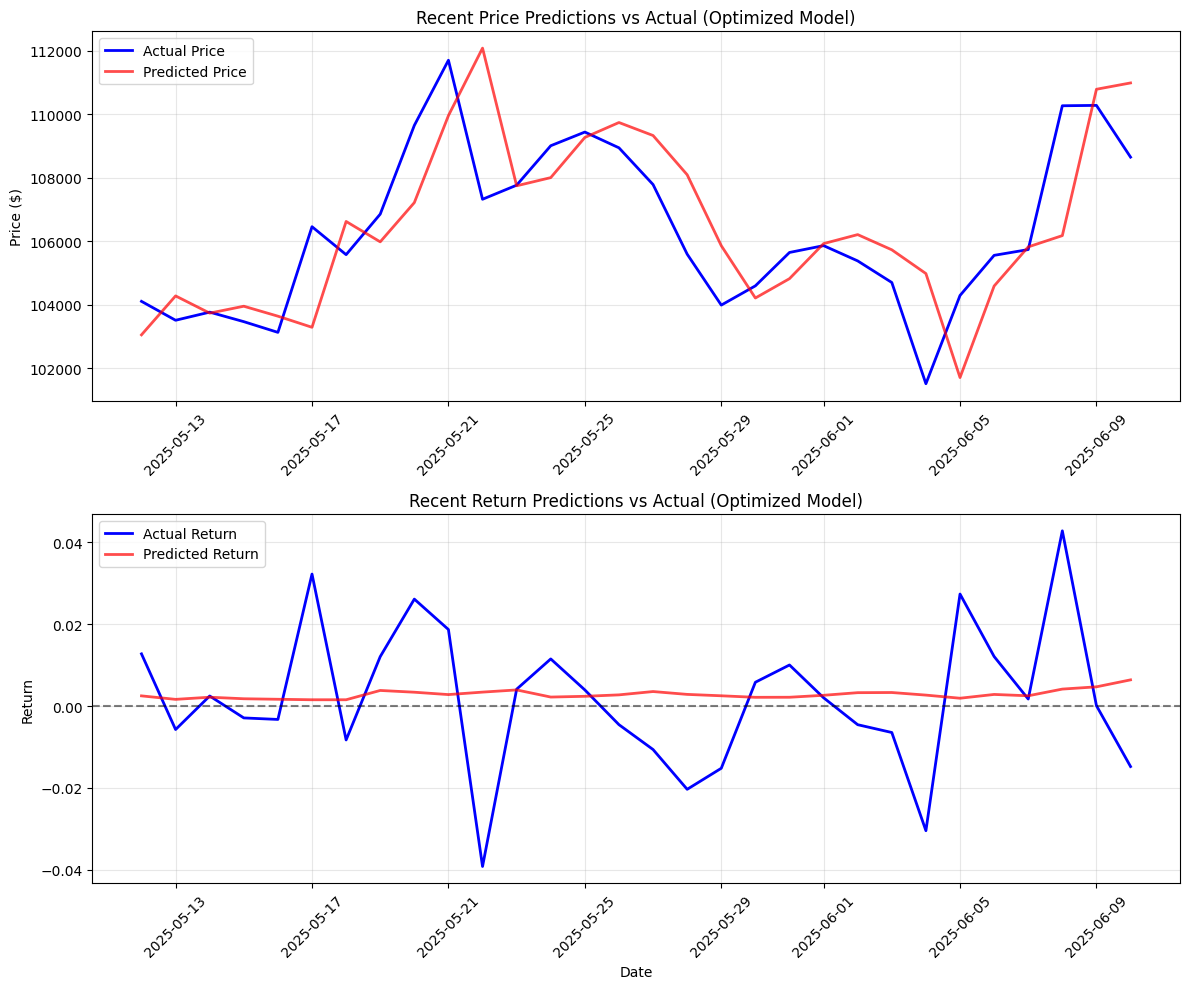

In [38]:
# Initialize the LSTM predictor
lstm_predictor = TunedBitcoinLSTMPredictor(df_daily)

# Engineer features
df_processed = lstm_predictor.engineer_features()

# Prepare data for LSTM training
lstm_predictor.prepare_data(test_size=0.2, val_size=0.1)

# Train models
return_hist, dir_hist = lstm_predictor.train_models(epochs=200, batch_size=32)

# Evaluate models
results = lstm_predictor.evaluate_models()

# Make next day prediction
next_day_pred = lstm_predictor.predict_next_day()

# Plot recent predictions
lstm_predictor.plot_predictions(results)
